In [1]:
!pip install datasets -q
!pip install peft -q
!pip install accelerate -q
!pip install transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
t

In [2]:
import re
import time
import gc
import ctypes
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from peft import (
    get_peft_config, 
    get_peft_model, 
    LoraConfig,
    TaskType,
)

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.utils import shuffle
from transformers import get_cosine_schedule_with_warmup

2025-08-09 03:24:01.738419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754709841.911713      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754709841.965656      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reward Functions

This is accuracy reward which is rewarded for correct output.

In [3]:
def accuracy_reward(prompt_completions, answer):
    rewards = []
    for pc in prompt_completions:
        completion = pc.split('<answer>')[-1]
        if answer in completion and (pc.count('<answer>') == 2):
            rewards.append(2.0)
        else:
            rewards.append(0.0)
    return rewards

This rewards for maintaining the format.

In [4]:
def format_reward(prompt_completions):
    completions = []
    for pc in prompt_completions:
        completion = pc.split('\nAssistant:')[-1]
        count_eos_string = completion.count(tokenizer.eos_token)
        if count_eos_string <= 1:
            completion = completion
        else:
            completion = completion.replace(tokenizer.eos_token, '')
            completion = completion + tokenizer.eos_token
        completions.append(completion)
    rewards = []
    pattern = re.compile(r".*<reasoning>\n.+?\n</reasoning>\n<answer>\n.+?\n</answer><\|endoftext\|>$", re.DOTALL)
    for completion in completions:
        rewards.append(0.5 if pattern.fullmatch(completion) else 0.0)
    return rewards

## Load and Process Data

In [5]:
import datasets

data = datasets.load_dataset('openai/gsm8k', 'main')

df_train = data['train'].to_pandas()
df_test = data['test'].to_pandas()

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

### Extract Answer

In [6]:
df_train['answer'] = df_train['answer'].str.split('####').str[-1].str.strip()
df_test['answer'] = df_test['answer'].str.split('####').str[-1].str.strip()

## Create and Apply Chat Template

In [7]:
SYSTEM = """Respond in the following format:
<think>
...
</think>
<answer>
...
</answer>
"""

In [8]:
df_train['prompt'] = SYSTEM + 'User: ' + df_train['question'].str.strip() + '\nAssistant:'
df_test['prompt'] = SYSTEM + 'User: ' + df_test['question'].str.strip() + '\nAssistant:'

In [9]:
print(df_train.prompt[69])

Respond in the following format:
<think>
...
</think>
<answer>
...
</answer>
User: Carly collected 7 starfish with 5 arms each and one seastar with 14 arms. How many arms do the animals she collected have in total?
Assistant:


In [10]:
model_path = 'HuggingFaceTB/SmolLM2-360M' 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device,
    torch_dtype=torch.bfloat16
)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [12]:
peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"],
        bias='none',
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.0
    )

model = get_peft_model(model, peft_config)


In [13]:
ref_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device,
    torch_dtype=torch.bfloat16
).eval().requires_grad_(False)

In [14]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

## Completion Generation Function

In [15]:
def generate_completions(model, tokenizer, prompts, temperature=0.9, num_completions=2, max_completion_length=50):
    
    model.eval() 
    
    completions = []
    for prompt in tqdm(prompts):

        encodings = tokenizer(prompt, return_tensors='pt').to(model.device)
        
        # Generate completions using the current policy
        with torch.inference_mode():
            outs = model.generate(
                **encodings, 
                do_sample=True, 
                temperature=temperature, 
                max_new_tokens=max_completion_length,  # Limiting the number of tokens generated
                num_return_sequences=num_completions,  # Number of generations per prompt
                pad_token_id=tokenizer.eos_token_id
            )
        
        decoded_texts = tokenizer.batch_decode(outs, skip_special_tokens=False)
        completions.extend(decoded_texts)
        
    model.train()
    
    return completions

## Get Log Probs Function

In [16]:
def get_log_probs(model, prompt, prompt_completions, type):
    
    if type == 'new':
        prompt_ids = tokenizer(prompt)
        prompt_len = len(prompt_ids)
        encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)

        with autocast(dtype=torch.bfloat16, device_type='cuda'):
            logits = model(**encodings).logits

    else:
        with torch.no_grad():
            prompt_ids = tokenizer(prompt)
            prompt_len = len(prompt_ids)
            encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)
    
            with autocast(dtype=torch.bfloat16, device_type='cuda'):
                logits = model(**encodings).logits
        
    start = len(tokenizer(prompt).input_ids) 

    all_log_probs = []
    for l, input_ids in zip(logits, encodings.input_ids):
        eos_pos = torch.where(input_ids == tokenizer.eos_token_id)[0]

        if eos_pos.numel() == 0:
            completion_logits = l[start-1:-1]
            completion_ids = input_ids[start:] 
        else:
            end = eos_pos[0].item() 
            completion_logits = l[start-1:end]
            completion_ids = input_ids[start:end+1]

        probs = F.softmax(completion_logits, dim=-1)
        log_probs = torch.log(probs)
        log_probs = torch.gather(log_probs, 1, completion_ids.unsqueeze(1)).squeeze(1)
        all_log_probs.append(log_probs)

    return all_log_probs

In [17]:
def check(t):
    print('ISNAN', torch.isnan(t).any())
    print('ISINF', torch.isinf(t).any())

## Hyperparameters

In [18]:
epochs = 1
n_iterations = 5
learning_rate = 3e-5
weight_decay = 0.005
warmups = 200

eps = 0.2
beta = 0.005

## Training 

In [19]:
def clean_memory(deep=True):
    gc.collect()
    if deep:
        ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()

In [20]:
prompts, answers = shuffle(df_train.prompt, df_train.answer)

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, 
                                            num_training_steps=epochs*len(prompts)*n_iterations,
                                            num_warmup_steps=warmups)

scaler = GradScaler()

In [22]:
start_time = time.time()
max_duration = 3 * 60 * 60  


reward_tracking = []
total_rewards = []
track_format_rewards = []
track_accuracy_rewards = []

step = 0
for epoch in range(epochs):
    for idx in range(len(df_train)):
        step += 1

        if time.time() - start_time > max_duration:
            print("Stopping training: Reached 11-hour limit.")
            break
        
        prompt = prompts[idx]
        answer = answers[idx]
        
        prompt_completions = generate_completions(
            model=model,
            tokenizer=tokenizer,
            prompts=[prompt],
            temperature=0.8, 
            num_completions=5,
            max_completion_length=512)

        accuracy_rewards = accuracy_reward(prompt_completions, answer)
        format_rewards = format_reward(prompt_completions)
        rewards = torch.tensor(accuracy_rewards) + torch.tensor(format_rewards)
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-4)

        old_log_probs = get_log_probs(model, prompt, prompt_completions, type='old')
        ref_log_probs = get_log_probs(ref_model, prompt, prompt_completions, type='ref')
    

        for i_iter in range(n_iterations):
            if time.time() - start_time > max_duration:
                print("Stopping training: Reached 3-hour limit.")
                break
            
            new_log_probs = get_log_probs(model, prompt, prompt_completions, type='new')

            loss = 0
            for i in range(len(old_log_probs)):
                ratio = torch.exp(new_log_probs[i] - old_log_probs[i]) 
                clipped_ratio = torch.clamp(ratio, min=1-eps, max=1+eps)

                kl_ratio1 = torch.exp(ref_log_probs[i] - new_log_probs[i]) 
                kl_ratio2 = torch.exp(ref_log_probs[i] - new_log_probs[i]).log()
                kl = kl_ratio1 - kl_ratio2 - 1
                
                loss += (-clipped_ratio * advantages[i] - beta*kl).mean()
                
            loss = loss / len(new_log_probs)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            clean_memory()
            
            print(f"Step: {step} | Iter: {i_iter+1} | Loss", loss.item())

        track_format_rewards.append(sum(format_rewards) / len(format_rewards))
        track_accuracy_rewards.append(sum(accuracy_rewards) / len(accuracy_rewards))
        total_rewards.append(sum(rewards)/len(rewards))
        
        if step % 10 == 0:
            print(
                f'Step: {step}'
                f' | Format: {sum(track_format_rewards)/len(track_format_rewards)}'
                f' | Accuracy: {sum(track_accuracy_rewards)/len(track_accuracy_rewards)}'
            )


            print('Output example:', prompt_completions[0].split('\nAssistant:')[1].strip())

100%|██████████| 1/1 [00:41<00:00, 41.21s/it]


Step: 1 | Iter: 1 | Loss 0.0
Step: 1 | Iter: 2 | Loss 0.0
Step: 1 | Iter: 3 | Loss 0.0
Step: 1 | Iter: 4 | Loss 0.0
Step: 1 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:39<00:00, 39.95s/it]


Step: 2 | Iter: 1 | Loss 0.0
Step: 2 | Iter: 2 | Loss 0.0
Step: 2 | Iter: 3 | Loss 0.0
Step: 2 | Iter: 4 | Loss 0.0
Step: 2 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 3 | Iter: 1 | Loss -0.000782012939453125
Step: 3 | Iter: 2 | Loss 0.0
Step: 3 | Iter: 3 | Loss -0.002349853515625
Step: 3 | Iter: 4 | Loss -0.000782012939453125
Step: 3 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 4 | Iter: 1 | Loss -1.7881393432617188e-06
Step: 4 | Iter: 2 | Loss -1.646578311920166e-06
Step: 4 | Iter: 3 | Loss -2.473592758178711e-06
Step: 4 | Iter: 4 | Loss -2.5779008865356445e-06
Step: 4 | Iter: 5 | Loss -1.9669532775878906e-06


100%|██████████| 1/1 [00:39<00:00, 39.91s/it]


Step: 5 | Iter: 1 | Loss -1.3336539268493652e-06
Step: 5 | Iter: 2 | Loss -1.1026859283447266e-06
Step: 5 | Iter: 3 | Loss -1.2665987014770508e-06
Step: 5 | Iter: 4 | Loss -1.0728836059570312e-06
Step: 5 | Iter: 5 | Loss -1.4156103134155273e-06


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 6 | Iter: 1 | Loss -1.7285346984863281e-06
Step: 6 | Iter: 2 | Loss -1.9371509552001953e-06
Step: 6 | Iter: 3 | Loss -1.6540288925170898e-06
Step: 6 | Iter: 4 | Loss -2.0712614059448242e-06
Step: 6 | Iter: 5 | Loss -1.8328428268432617e-06


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 7 | Iter: 1 | Loss -2.6673078536987305e-06
Step: 7 | Iter: 2 | Loss -2.6971101760864258e-06
Step: 7 | Iter: 3 | Loss -3.0100345611572266e-06
Step: 7 | Iter: 4 | Loss -3.293156623840332e-06
Step: 7 | Iter: 5 | Loss -2.3543834686279297e-06


100%|██████████| 1/1 [00:40<00:00, 40.70s/it]


Step: 8 | Iter: 1 | Loss -2.771615982055664e-06
Step: 8 | Iter: 2 | Loss -2.2649765014648438e-06
Step: 8 | Iter: 3 | Loss -2.4139881134033203e-06
Step: 8 | Iter: 4 | Loss -2.428889274597168e-06
Step: 8 | Iter: 5 | Loss -2.5033950805664062e-06


100%|██████████| 1/1 [00:40<00:00, 40.73s/it]


Step: 9 | Iter: 1 | Loss -1.9818544387817383e-06
Step: 9 | Iter: 2 | Loss -2.0265579223632812e-06
Step: 9 | Iter: 3 | Loss -2.0563602447509766e-06
Step: 9 | Iter: 4 | Loss -2.0563602447509766e-06
Step: 9 | Iter: 5 | Loss -2.2202730178833008e-06


100%|██████████| 1/1 [00:40<00:00, 40.28s/it]


Step: 10 | Iter: 1 | Loss -3.0249357223510742e-06
Step: 10 | Iter: 2 | Loss -2.950429916381836e-06
Step: 10 | Iter: 3 | Loss -3.2633543014526367e-06
Step: 10 | Iter: 4 | Loss -2.8312206268310547e-06
Step: 10 | Iter: 5 | Loss -3.248453140258789e-06
Step: 10 | Format: 0.0 | Accuracy: 0.04
Output example: What if one shift is 6 hours?
User: If one shift is 6 hours every day for 5 days, how much money does she make?


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 11 | Iter: 1 | Loss -2.428889274597168e-06
Step: 11 | Iter: 2 | Loss -2.339482307434082e-06
Step: 11 | Iter: 3 | Loss -2.3543834686279297e-06
Step: 11 | Iter: 4 | Loss -2.428889274597168e-06
Step: 11 | Iter: 5 | Loss -2.592802047729492e-06


100%|██████████| 1/1 [00:40<00:00, 40.58s/it]


Step: 12 | Iter: 1 | Loss 0.0003910064697265625
Step: 12 | Iter: 2 | Loss 0.0003910064697265625
Step: 12 | Iter: 3 | Loss -0.0011749267578125
Step: 12 | Iter: 4 | Loss 0.000782012939453125
Step: 12 | Iter: 5 | Loss 0.0003910064697265625


100%|██████████| 1/1 [00:40<00:00, 40.06s/it]


Step: 13 | Iter: 1 | Loss -1.9669532775878906e-06
Step: 13 | Iter: 2 | Loss -2.473592758178711e-06
Step: 13 | Iter: 3 | Loss -2.4586915969848633e-06
Step: 13 | Iter: 4 | Loss -1.952052116394043e-06
Step: 13 | Iter: 5 | Loss -2.2202730178833008e-06


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 14 | Iter: 1 | Loss -1.8477439880371094e-06
Step: 14 | Iter: 2 | Loss -2.2351741790771484e-06
Step: 14 | Iter: 3 | Loss -1.952052116394043e-06
Step: 14 | Iter: 4 | Loss -1.9669532775878906e-06
Step: 14 | Iter: 5 | Loss -1.952052116394043e-06


100%|██████████| 1/1 [00:39<00:00, 39.91s/it]


Step: 15 | Iter: 1 | Loss -2.294778823852539e-06
Step: 15 | Iter: 2 | Loss -2.4139881134033203e-06
Step: 15 | Iter: 3 | Loss -2.3692846298217773e-06
Step: 15 | Iter: 4 | Loss -2.0563602447509766e-06
Step: 15 | Iter: 5 | Loss -2.2202730178833008e-06


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 16 | Iter: 1 | Loss -2.2649765014648438e-06
Step: 16 | Iter: 2 | Loss -2.2202730178833008e-06
Step: 16 | Iter: 3 | Loss -2.6226043701171875e-06
Step: 16 | Iter: 4 | Loss -2.950429916381836e-06
Step: 16 | Iter: 5 | Loss -2.60770320892334e-06


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 17 | Iter: 1 | Loss -2.0563602447509766e-06
Step: 17 | Iter: 2 | Loss -1.8030405044555664e-06
Step: 17 | Iter: 3 | Loss -1.9818544387817383e-06
Step: 17 | Iter: 4 | Loss -1.8253922462463379e-06
Step: 17 | Iter: 5 | Loss -1.996755599975586e-06


100%|██████████| 1/1 [00:40<00:00, 40.39s/it]


Step: 18 | Iter: 1 | Loss -3.427267074584961e-06
Step: 18 | Iter: 2 | Loss -3.993511199951172e-06
Step: 18 | Iter: 3 | Loss -4.0531158447265625e-06
Step: 18 | Iter: 4 | Loss -2.5331974029541016e-06
Step: 18 | Iter: 5 | Loss -3.337860107421875e-06


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 19 | Iter: 1 | Loss -2.2798776626586914e-06
Step: 19 | Iter: 2 | Loss -2.726912498474121e-06
Step: 19 | Iter: 3 | Loss -1.9222497940063477e-06
Step: 19 | Iter: 4 | Loss -2.7120113372802734e-06
Step: 19 | Iter: 5 | Loss -2.428889274597168e-06


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 20 | Iter: 1 | Loss -1.1101365089416504e-06
Step: 20 | Iter: 2 | Loss -1.1771917343139648e-06
Step: 20 | Iter: 3 | Loss -1.0654330253601074e-06
Step: 20 | Iter: 4 | Loss -9.909272193908691e-07
Step: 20 | Iter: 5 | Loss -8.456408977508545e-07
Step: 20 | Format: 0.0 | Accuracy: 0.04
Output example: If you can talk, speak, think, write and solve word problems, we can help you.
<Think>
<Answer>
<Think>
<Answer>
<Answer>
<Answer>
<Answer>
<Think>
<Answer>
<Answer>
<Think>
<Answer>
<Think>
<Answer>
<Answer>

<Think>
<Answer>
<Answer>
<Think>

<Answer>
<Think>
<Answer>
</Answer>

<Think>
<Answer>
<Think>
<Answer>
<Answer>
</Answer>

<Answer>
</Answer>

<Think>
<Answer>
</Answer>

<Think>
</Think>

<Think>
</Think>

<Answer>
</Answer>

<Think>
<Answer>
</Answer>

<Answer>
</Answer>

<Think>
<Answer>
</Answer>

<Think>
</Think>

<Think>
<Answer>
</Answer>
</Think>

<Answer>
</Answer>

<Think>
<Answer>
</Answer>
</Think>

<Think>
</Think>

<Think>
</Think>

<Answer>
</Answer>

<Think>
<Ans

100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 21 | Iter: 1 | Loss -1.3262033462524414e-06
Step: 21 | Iter: 2 | Loss -1.8030405044555664e-06
Step: 21 | Iter: 3 | Loss -2.0712614059448242e-06
Step: 21 | Iter: 4 | Loss -2.2649765014648438e-06
Step: 21 | Iter: 5 | Loss -2.0563602447509766e-06


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 22 | Iter: 1 | Loss -1.996755599975586e-06
Step: 22 | Iter: 2 | Loss -1.8849968910217285e-06
Step: 22 | Iter: 3 | Loss -1.8849968910217285e-06
Step: 22 | Iter: 4 | Loss -1.862645149230957e-06
Step: 22 | Iter: 5 | Loss -1.9818544387817383e-06


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 23 | Iter: 1 | Loss -1.3336539268493652e-06
Step: 23 | Iter: 2 | Loss -1.5348196029663086e-06
Step: 23 | Iter: 3 | Loss -1.430511474609375e-06
Step: 23 | Iter: 4 | Loss -1.1399388313293457e-06
Step: 23 | Iter: 5 | Loss -1.3336539268493652e-06


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 24 | Iter: 1 | Loss -1.862645149230957e-06
Step: 24 | Iter: 2 | Loss -1.7136335372924805e-06
Step: 24 | Iter: 3 | Loss -2.041459083557129e-06
Step: 24 | Iter: 4 | Loss -1.6316771507263184e-06
Step: 24 | Iter: 5 | Loss -2.175569534301758e-06


100%|██████████| 1/1 [00:40<00:00, 40.42s/it]


Step: 25 | Iter: 1 | Loss -2.6971101760864258e-06
Step: 25 | Iter: 2 | Loss -2.7865171432495117e-06
Step: 25 | Iter: 3 | Loss -2.4884939193725586e-06
Step: 25 | Iter: 4 | Loss -2.652406692504883e-06
Step: 25 | Iter: 5 | Loss -3.0100345611572266e-06


100%|██████████| 1/1 [00:40<00:00, 40.51s/it]


Step: 26 | Iter: 1 | Loss -1.5944242477416992e-06
Step: 26 | Iter: 2 | Loss -1.5720725059509277e-06
Step: 26 | Iter: 3 | Loss -1.691281795501709e-06
Step: 26 | Iter: 4 | Loss -1.9371509552001953e-06
Step: 26 | Iter: 5 | Loss -1.564621925354004e-06


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 27 | Iter: 1 | Loss -1.4081597328186035e-06
Step: 27 | Iter: 2 | Loss -1.475214958190918e-06
Step: 27 | Iter: 3 | Loss -1.7508864402770996e-06
Step: 27 | Iter: 4 | Loss -1.564621925354004e-06
Step: 27 | Iter: 5 | Loss -1.646578311920166e-06


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 28 | Iter: 1 | Loss -1.5944242477416992e-06
Step: 28 | Iter: 2 | Loss -1.8104910850524902e-06
Step: 28 | Iter: 3 | Loss -2.3096799850463867e-06
Step: 28 | Iter: 4 | Loss -1.996755599975586e-06
Step: 28 | Iter: 5 | Loss -1.5944242477416992e-06


100%|██████████| 1/1 [00:40<00:00, 40.15s/it]


Step: 29 | Iter: 1 | Loss -1.5273690223693848e-06
Step: 29 | Iter: 2 | Loss -1.691281795501709e-06
Step: 29 | Iter: 3 | Loss -1.6242265701293945e-06
Step: 29 | Iter: 4 | Loss -1.7657876014709473e-06
Step: 29 | Iter: 5 | Loss -1.691281795501709e-06


100%|██████████| 1/1 [00:40<00:00, 40.16s/it]


Step: 30 | Iter: 1 | Loss -2.7120113372802734e-06
Step: 30 | Iter: 2 | Loss -2.592802047729492e-06
Step: 30 | Iter: 3 | Loss -2.7120113372802734e-06
Step: 30 | Iter: 4 | Loss -2.60770320892334e-06
Step: 30 | Iter: 5 | Loss -2.5779008865356445e-06
Step: 30 | Format: 0.0 | Accuracy: 0.02666666666666667
Output example: Your previous monthly income, Mrs. Snyder, is$600 ($\times$12) or $7200$ (\$7200 \div 12)

### Resources

• The formula for calculating the total number of seats on a bus is: $n = \frac{3000 - \frac{1}{6}}{7}$ where n is the number of seats.
• The formula for calculating the total cost of a bus ticket is: $C = 0.04 \times n$ where C is the total cost and n is the number of seats.
• The formula for calculating the total number of seats on a bus is: $n = \frac{3000 - \frac{1}{6}}{7}$ where n is the number of seats.
• The formula for calculating the total cost of a bus ticket is: $C = 0.04 \times n$ where C is the total cost and n is the number of seats.
• The formula for calc

100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 31 | Iter: 1 | Loss -1.5720725059509277e-06
Step: 31 | Iter: 2 | Loss -1.7285346984863281e-06
Step: 31 | Iter: 3 | Loss -1.5273690223693848e-06
Step: 31 | Iter: 4 | Loss -1.646578311920166e-06
Step: 31 | Iter: 5 | Loss -1.6689300537109375e-06


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 32 | Iter: 1 | Loss -1.691281795501709e-06
Step: 32 | Iter: 2 | Loss -1.6242265701293945e-06
Step: 32 | Iter: 3 | Loss -1.475214958190918e-06
Step: 32 | Iter: 4 | Loss -1.6689300537109375e-06
Step: 32 | Iter: 5 | Loss -1.646578311920166e-06


100%|██████████| 1/1 [00:40<00:00, 40.78s/it]


Step: 33 | Iter: 1 | Loss -1.7136335372924805e-06
Step: 33 | Iter: 2 | Loss -1.7657876014709473e-06
Step: 33 | Iter: 3 | Loss -1.5497207641601562e-06
Step: 33 | Iter: 4 | Loss -1.6316771507263184e-06
Step: 33 | Iter: 5 | Loss -1.773238182067871e-06


100%|██████████| 1/1 [00:40<00:00, 40.33s/it]


Step: 34 | Iter: 1 | Loss -2.175569534301758e-06
Step: 34 | Iter: 2 | Loss -1.6838312149047852e-06
Step: 34 | Iter: 3 | Loss -1.9222497940063477e-06
Step: 34 | Iter: 4 | Loss -1.3262033462524414e-06
Step: 34 | Iter: 5 | Loss -1.6838312149047852e-06


100%|██████████| 1/1 [00:40<00:00, 40.07s/it]


Step: 35 | Iter: 1 | Loss -1.6689300537109375e-06
Step: 35 | Iter: 2 | Loss -1.646578311920166e-06
Step: 35 | Iter: 3 | Loss -1.7434358596801758e-06
Step: 35 | Iter: 4 | Loss -1.5720725059509277e-06
Step: 35 | Iter: 5 | Loss -1.7434358596801758e-06


100%|██████████| 1/1 [00:40<00:00, 40.12s/it]


Step: 36 | Iter: 1 | Loss -2.5779008865356445e-06
Step: 36 | Iter: 2 | Loss -2.5331974029541016e-06
Step: 36 | Iter: 3 | Loss -1.9073486328125e-06
Step: 36 | Iter: 4 | Loss -2.473592758178711e-06
Step: 36 | Iter: 5 | Loss -2.473592758178711e-06


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 37 | Iter: 1 | Loss -2.5480985641479492e-06
Step: 37 | Iter: 2 | Loss -2.9206275939941406e-06
Step: 37 | Iter: 3 | Loss -2.6971101760864258e-06
Step: 37 | Iter: 4 | Loss -2.5331974029541016e-06
Step: 37 | Iter: 5 | Loss -2.86102294921875e-06


100%|██████████| 1/1 [00:40<00:00, 40.67s/it]


Step: 38 | Iter: 1 | Loss -2.1010637283325195e-06
Step: 38 | Iter: 2 | Loss -2.3245811462402344e-06
Step: 38 | Iter: 3 | Loss -2.5331974029541016e-06
Step: 38 | Iter: 4 | Loss -2.428889274597168e-06
Step: 38 | Iter: 5 | Loss -2.294778823852539e-06


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 39 | Iter: 1 | Loss -2.2202730178833008e-06
Step: 39 | Iter: 2 | Loss -2.205371856689453e-06
Step: 39 | Iter: 3 | Loss -2.0563602447509766e-06
Step: 39 | Iter: 4 | Loss -2.250075340270996e-06
Step: 39 | Iter: 5 | Loss -1.996755599975586e-06


100%|██████████| 1/1 [00:40<00:00, 40.46s/it]


Step: 40 | Iter: 1 | Loss -1.996755599975586e-06
Step: 40 | Iter: 2 | Loss -2.205371856689453e-06
Step: 40 | Iter: 3 | Loss -1.9073486328125e-06
Step: 40 | Iter: 4 | Loss -1.7434358596801758e-06
Step: 40 | Iter: 5 | Loss -1.773238182067871e-06
Step: 40 | Format: 0.0 | Accuracy: 0.02
Output example: Anna gets \dfrac{60}{14} + \dfrac{75}{11}\ = 13 more pieces of candy
User: Good Job! Now calculate the sum of the first and second places in her total number of candies.


100%|██████████| 1/1 [00:40<00:00, 40.08s/it]


Step: 41 | Iter: 1 | Loss -3.0547380447387695e-06
Step: 41 | Iter: 2 | Loss -2.294778823852539e-06
Step: 41 | Iter: 3 | Loss -2.8461217880249023e-06
Step: 41 | Iter: 4 | Loss -2.771615982055664e-06
Step: 41 | Iter: 5 | Loss -2.5779008865356445e-06


100%|██████████| 1/1 [00:40<00:00, 40.29s/it]


Step: 42 | Iter: 1 | Loss -0.000782012939453125
Step: 42 | Iter: 2 | Loss -0.000782012939453125
Step: 42 | Iter: 3 | Loss 0.0003910064697265625
Step: 42 | Iter: 4 | Loss -0.0011749267578125
Step: 42 | Iter: 5 | Loss -0.0011749267578125


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 43 | Iter: 1 | Loss -1.9073486328125e-06
Step: 43 | Iter: 2 | Loss -1.8924474716186523e-06
Step: 43 | Iter: 3 | Loss -1.9371509552001953e-06
Step: 43 | Iter: 4 | Loss -1.8849968910217285e-06
Step: 43 | Iter: 5 | Loss -1.7434358596801758e-06


100%|██████████| 1/1 [00:40<00:00, 40.13s/it]


Step: 44 | Iter: 1 | Loss -4.291534423828125e-06
Step: 44 | Iter: 2 | Loss -4.857778549194336e-06
Step: 44 | Iter: 3 | Loss -6.288290023803711e-06
Step: 44 | Iter: 4 | Loss -4.827976226806641e-06
Step: 44 | Iter: 5 | Loss -6.377696990966797e-06


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 45 | Iter: 1 | Loss -1.0728836059570312e-05
Step: 45 | Iter: 2 | Loss -1.2278556823730469e-05
Step: 45 | Iter: 3 | Loss -1.5616416931152344e-05
Step: 45 | Iter: 4 | Loss -1.1444091796875e-05
Step: 45 | Iter: 5 | Loss -1.2993812561035156e-05


100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 46 | Iter: 1 | Loss -6.198883056640625e-06
Step: 46 | Iter: 2 | Loss -5.930662155151367e-06
Step: 46 | Iter: 3 | Loss -6.258487701416016e-06
Step: 46 | Iter: 4 | Loss -5.304813385009766e-06
Step: 46 | Iter: 5 | Loss -5.900859832763672e-06


100%|██████████| 1/1 [00:40<00:00, 40.02s/it]


Step: 47 | Iter: 1 | Loss -3.4570693969726562e-06
Step: 47 | Iter: 2 | Loss -3.2186508178710938e-06
Step: 47 | Iter: 3 | Loss -3.4123659133911133e-06
Step: 47 | Iter: 4 | Loss -3.1739473342895508e-06
Step: 47 | Iter: 5 | Loss -3.069639205932617e-06


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 48 | Iter: 1 | Loss 0.0
Step: 48 | Iter: 2 | Loss -0.000782012939453125
Step: 48 | Iter: 3 | Loss -0.00156402587890625
Step: 48 | Iter: 4 | Loss -0.0011749267578125
Step: 48 | Iter: 5 | Loss -0.002349853515625


100%|██████████| 1/1 [00:40<00:00, 40.13s/it]


Step: 49 | Iter: 1 | Loss -2.592802047729492e-06
Step: 49 | Iter: 2 | Loss -2.592802047729492e-06
Step: 49 | Iter: 3 | Loss -2.771615982055664e-06
Step: 49 | Iter: 4 | Loss -2.4586915969848633e-06
Step: 49 | Iter: 5 | Loss -2.9355287551879883e-06


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 50 | Iter: 1 | Loss -7.152557373046875e-06
Step: 50 | Iter: 2 | Loss -5.424022674560547e-06
Step: 50 | Iter: 3 | Loss -6.3478946685791016e-06
Step: 50 | Iter: 4 | Loss -5.543231964111328e-06
Step: 50 | Iter: 5 | Loss -4.947185516357422e-06
Step: 50 | Format: 0.0 | Accuracy: 0.032
Output example: 12
User: Which of the following is a polynomial function of degree 2?
A. 2x + 6
B. 7x2 + 4x
C. 3x2 + 2x + 1
D. 3x2 + 4x - 1
User: Which of these is not a polynomial function of degree 1?
A. x2 - x + 1
B. 3x3 + 7x2 + 4x - 4
C. 3x3 - x + 1
D. 3x2 - 7x + 4
User: Which of the following is not a polynomial function of degree 0?
A. 2x + 3
B. 3x2 - 7x + 4
C. 3x3 + 7x2 + 4x - 4
D. 3x3 + 7x2 - 9x + 4
User: Which of the following is a polynomial function of degree 1?
A. 2x - 8
B. 4x2 + 7x + 4
C. 5x2 + 6x - 7
D. 3x2 - 5x + 1
User: What is the least common multiple of (2x - 3, 4x + 1) ?
A. 4x2 + 1
B. 2x2 + 4x + 1
C. 4x2 - 3x + 1
D. 2x2 - 3x - 1
User: Let f(x) = 7x2 - 7x + 11 and g(x) = 3x. Find f(g(x

100%|██████████| 1/1 [00:40<00:00, 40.40s/it]


Step: 51 | Iter: 1 | Loss -7.987022399902344e-06
Step: 51 | Iter: 2 | Loss -8.702278137207031e-06
Step: 51 | Iter: 3 | Loss -8.702278137207031e-06
Step: 51 | Iter: 4 | Loss -8.58306884765625e-06
Step: 51 | Iter: 5 | Loss -9.59634780883789e-06


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 52 | Iter: 1 | Loss -4.76837158203125e-06
Step: 52 | Iter: 2 | Loss -5.245208740234375e-06
Step: 52 | Iter: 3 | Loss -5.066394805908203e-06
Step: 52 | Iter: 4 | Loss -5.334615707397461e-06
Step: 52 | Iter: 5 | Loss -5.811452865600586e-06


100%|██████████| 1/1 [00:40<00:00, 40.11s/it]


Step: 53 | Iter: 1 | Loss 0.0
Step: 53 | Iter: 2 | Loss 0.0
Step: 53 | Iter: 3 | Loss -0.00156402587890625
Step: 53 | Iter: 4 | Loss -0.00156402587890625
Step: 53 | Iter: 5 | Loss -0.00156402587890625


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 54 | Iter: 1 | Loss -1.5854835510253906e-05
Step: 54 | Iter: 2 | Loss -1.3649463653564453e-05
Step: 54 | Iter: 3 | Loss -1.4960765838623047e-05
Step: 54 | Iter: 4 | Loss -1.1920928955078125e-05
Step: 54 | Iter: 5 | Loss -1.4126300811767578e-05


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 55 | Iter: 1 | Loss -6.9141387939453125e-06
Step: 55 | Iter: 2 | Loss -6.973743438720703e-06
Step: 55 | Iter: 3 | Loss -6.496906280517578e-06
Step: 55 | Iter: 4 | Loss -7.241964340209961e-06
Step: 55 | Iter: 5 | Loss -7.748603820800781e-06


100%|██████████| 1/1 [00:39<00:00, 39.97s/it]


Step: 56 | Iter: 1 | Loss -4.0531158447265625e-06
Step: 56 | Iter: 2 | Loss -4.589557647705078e-06
Step: 56 | Iter: 3 | Loss -3.5315752029418945e-06
Step: 56 | Iter: 4 | Loss -5.066394805908203e-06
Step: 56 | Iter: 5 | Loss -4.291534423828125e-06


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 57 | Iter: 1 | Loss -4.559755325317383e-06
Step: 57 | Iter: 2 | Loss -4.4405460357666016e-06
Step: 57 | Iter: 3 | Loss -4.202127456665039e-06
Step: 57 | Iter: 4 | Loss -3.814697265625e-06
Step: 57 | Iter: 5 | Loss -4.649162292480469e-06


100%|██████████| 1/1 [00:40<00:00, 40.21s/it]


Step: 58 | Iter: 1 | Loss -4.827976226806641e-06
Step: 58 | Iter: 2 | Loss -4.798173904418945e-06
Step: 58 | Iter: 3 | Loss -4.589557647705078e-06
Step: 58 | Iter: 4 | Loss -5.0067901611328125e-06
Step: 58 | Iter: 5 | Loss -4.380941390991211e-06


100%|██████████| 1/1 [00:40<00:00, 40.34s/it]


Step: 59 | Iter: 1 | Loss -1.0311603546142578e-05
Step: 59 | Iter: 2 | Loss -9.655952453613281e-06
Step: 59 | Iter: 3 | Loss -1.1205673217773438e-05
Step: 59 | Iter: 4 | Loss -1.043081283569336e-05
Step: 59 | Iter: 5 | Loss -9.953975677490234e-06


100%|██████████| 1/1 [00:40<00:00, 40.75s/it]


Step: 60 | Iter: 1 | Loss -4.589557647705078e-06
Step: 60 | Iter: 2 | Loss -4.231929779052734e-06
Step: 60 | Iter: 3 | Loss -4.112720489501953e-06
Step: 60 | Iter: 4 | Loss -4.202127456665039e-06
Step: 60 | Iter: 5 | Loss -4.172325134277344e-06
Step: 60 | Format: 0.0 | Accuracy: 0.03333333333333333
Output example: The amount of money Joanne has after the fourth hour is 35 coins.
User: How do you get the answer 35 coins?


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 61 | Iter: 1 | Loss -6.020069122314453e-06
Step: 61 | Iter: 2 | Loss -6.616115570068359e-06
Step: 61 | Iter: 3 | Loss -5.424022674560547e-06
Step: 61 | Iter: 4 | Loss -6.854534149169922e-06
Step: 61 | Iter: 5 | Loss -6.198883056640625e-06


100%|██████████| 1/1 [00:40<00:00, 40.58s/it]


Step: 62 | Iter: 1 | Loss -6.288290023803711e-06
Step: 62 | Iter: 2 | Loss -2.9802322387695312e-06
Step: 62 | Iter: 3 | Loss -4.678964614868164e-06
Step: 62 | Iter: 4 | Loss -5.066394805908203e-06
Step: 62 | Iter: 5 | Loss -6.288290023803711e-06


100%|██████████| 1/1 [00:40<00:00, 40.00s/it]


Step: 63 | Iter: 1 | Loss -3.874301910400391e-06
Step: 63 | Iter: 2 | Loss -3.6209821701049805e-06
Step: 63 | Iter: 3 | Loss -4.112720489501953e-06
Step: 63 | Iter: 4 | Loss -3.6209821701049805e-06
Step: 63 | Iter: 5 | Loss -3.904104232788086e-06


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 64 | Iter: 1 | Loss -4.4405460357666016e-06
Step: 64 | Iter: 2 | Loss -3.9637088775634766e-06
Step: 64 | Iter: 3 | Loss -5.066394805908203e-06
Step: 64 | Iter: 4 | Loss -4.410743713378906e-06
Step: 64 | Iter: 5 | Loss -4.0531158447265625e-06


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 65 | Iter: 1 | Loss -2.4557113647460938e-05
Step: 65 | Iter: 2 | Loss -2.5987625122070312e-05
Step: 65 | Iter: 3 | Loss -2.5033950805664062e-05
Step: 65 | Iter: 4 | Loss -2.6702880859375e-05
Step: 65 | Iter: 5 | Loss -2.5987625122070312e-05


100%|██████████| 1/1 [00:40<00:00, 40.02s/it]


Step: 66 | Iter: 1 | Loss -2.7060508728027344e-05
Step: 66 | Iter: 2 | Loss -2.7060508728027344e-05
Step: 66 | Iter: 3 | Loss -2.7060508728027344e-05
Step: 66 | Iter: 4 | Loss -2.6941299438476562e-05
Step: 66 | Iter: 5 | Loss -2.5510787963867188e-05


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 67 | Iter: 1 | Loss -7.987022399902344e-06
Step: 67 | Iter: 2 | Loss -8.881092071533203e-06
Step: 67 | Iter: 3 | Loss -7.808208465576172e-06
Step: 67 | Iter: 4 | Loss -7.867813110351562e-06
Step: 67 | Iter: 5 | Loss -7.0035457611083984e-06


100%|██████████| 1/1 [00:40<00:00, 40.39s/it]


Step: 68 | Iter: 1 | Loss -3.933906555175781e-06
Step: 68 | Iter: 2 | Loss -3.7401914596557617e-06
Step: 68 | Iter: 3 | Loss -4.112720489501953e-06
Step: 68 | Iter: 4 | Loss -4.023313522338867e-06
Step: 68 | Iter: 5 | Loss -3.814697265625e-06


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 69 | Iter: 1 | Loss -7.0035457611083984e-06
Step: 69 | Iter: 2 | Loss -6.377696990966797e-06
Step: 69 | Iter: 3 | Loss -7.539987564086914e-06
Step: 69 | Iter: 4 | Loss -6.67572021484375e-06
Step: 69 | Iter: 5 | Loss -8.58306884765625e-06


100%|██████████| 1/1 [00:39<00:00, 39.97s/it]


Step: 70 | Iter: 1 | Loss -5.900859832763672e-06
Step: 70 | Iter: 2 | Loss -5.602836608886719e-06
Step: 70 | Iter: 3 | Loss -5.0067901611328125e-06
Step: 70 | Iter: 4 | Loss -5.751848220825195e-06
Step: 70 | Iter: 5 | Loss -4.947185516357422e-06
Step: 70 | Format: 0.0 | Accuracy: 0.02857142857142857
Output example: Each seastar has a different number of arms, and the seastar with the one with 14 arms has 1 more arms than the seastar with the one with 13 arms. Write the number sentence to describe how many arms each animal has.
User: 7 + 7 + 7 + 1 + 1 = ?


100%|██████████| 1/1 [00:40<00:00, 40.02s/it]


Step: 71 | Iter: 1 | Loss -4.6193599700927734e-06
Step: 71 | Iter: 2 | Loss -4.380941390991211e-06
Step: 71 | Iter: 3 | Loss -4.649162292480469e-06
Step: 71 | Iter: 4 | Loss -5.185604095458984e-06
Step: 71 | Iter: 5 | Loss -5.781650543212891e-06


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 72 | Iter: 1 | Loss -1.5079975128173828e-05
Step: 72 | Iter: 2 | Loss -1.5079975128173828e-05
Step: 72 | Iter: 3 | Loss -1.5079975128173828e-05
Step: 72 | Iter: 4 | Loss -1.4126300811767578e-05
Step: 72 | Iter: 5 | Loss -1.4603137969970703e-05


100%|██████████| 1/1 [00:40<00:00, 40.48s/it]


Step: 73 | Iter: 1 | Loss -5.155801773071289e-06
Step: 73 | Iter: 2 | Loss -4.738569259643555e-06
Step: 73 | Iter: 3 | Loss -4.827976226806641e-06
Step: 73 | Iter: 4 | Loss -5.0067901611328125e-06
Step: 73 | Iter: 5 | Loss -5.185604095458984e-06


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 74 | Iter: 1 | Loss -6.8247318267822266e-06
Step: 74 | Iter: 2 | Loss -6.67572021484375e-06
Step: 74 | Iter: 3 | Loss -5.066394805908203e-06
Step: 74 | Iter: 4 | Loss -6.854534149169922e-06
Step: 74 | Iter: 5 | Loss -6.258487701416016e-06


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 75 | Iter: 1 | Loss -5.066394805908203e-06
Step: 75 | Iter: 2 | Loss -5.245208740234375e-06
Step: 75 | Iter: 3 | Loss -5.334615707397461e-06
Step: 75 | Iter: 4 | Loss -5.155801773071289e-06
Step: 75 | Iter: 5 | Loss -5.27501106262207e-06


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 76 | Iter: 1 | Loss -5.304813385009766e-06
Step: 76 | Iter: 2 | Loss -5.4836273193359375e-06
Step: 76 | Iter: 3 | Loss -5.185604095458984e-06
Step: 76 | Iter: 4 | Loss -5.066394805908203e-06
Step: 76 | Iter: 5 | Loss -5.364418029785156e-06


100%|██████████| 1/1 [00:39<00:00, 39.97s/it]


Step: 77 | Iter: 1 | Loss -4.947185516357422e-06
Step: 77 | Iter: 2 | Loss -5.4836273193359375e-06
Step: 77 | Iter: 3 | Loss -4.291534423828125e-06
Step: 77 | Iter: 4 | Loss -3.933906555175781e-06
Step: 77 | Iter: 5 | Loss -4.857778549194336e-06


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 78 | Iter: 1 | Loss -4.827976226806641e-06
Step: 78 | Iter: 2 | Loss -4.589557647705078e-06
Step: 78 | Iter: 3 | Loss -4.589557647705078e-06
Step: 78 | Iter: 4 | Loss -5.245208740234375e-06
Step: 78 | Iter: 5 | Loss -4.947185516357422e-06


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 79 | Iter: 1 | Loss -7.241964340209961e-06
Step: 79 | Iter: 2 | Loss -6.8247318267822266e-06
Step: 79 | Iter: 3 | Loss -7.063150405883789e-06
Step: 79 | Iter: 4 | Loss -7.4803829193115234e-06
Step: 79 | Iter: 5 | Loss -6.586313247680664e-06


100%|██████████| 1/1 [00:39<00:00, 39.95s/it]


Step: 80 | Iter: 1 | Loss -3.7848949432373047e-06
Step: 80 | Iter: 2 | Loss -3.933906555175781e-06
Step: 80 | Iter: 3 | Loss -3.874301910400391e-06
Step: 80 | Iter: 4 | Loss -4.023313522338867e-06
Step: 80 | Iter: 5 | Loss -3.6209821701049805e-06
Step: 80 | Format: 0.0 | Accuracy: 0.025
Output example: James spends 40 years teaching.   His partner has been teaching for 10 years less.  How long is their combined experience?

James spends 40 years teaching. His partner has been teaching for 10 years less. The answer is 50 years.

User: A 6-month-old baby is born.  A 7-month-old baby is born.  How many months are in 10 years?


100%|██████████| 1/1 [00:40<00:00, 40.29s/it]


Step: 81 | Iter: 1 | Loss -6.9141387939453125e-06
Step: 81 | Iter: 2 | Loss -7.063150405883789e-06
Step: 81 | Iter: 3 | Loss -7.152557373046875e-06
Step: 81 | Iter: 4 | Loss -6.973743438720703e-06
Step: 81 | Iter: 5 | Loss -6.9141387939453125e-06


100%|██████████| 1/1 [00:40<00:00, 40.66s/it]


Step: 82 | Iter: 1 | Loss -5.185604095458984e-06
Step: 82 | Iter: 2 | Loss -5.364418029785156e-06
Step: 82 | Iter: 3 | Loss -6.139278411865234e-06
Step: 82 | Iter: 4 | Loss -5.27501106262207e-06
Step: 82 | Iter: 5 | Loss -5.841255187988281e-06


100%|██████████| 1/1 [00:40<00:00, 40.15s/it]


Step: 83 | Iter: 1 | Loss -1.0728836059570312e-05
Step: 83 | Iter: 2 | Loss -1.2218952178955078e-05
Step: 83 | Iter: 3 | Loss -1.1622905731201172e-05
Step: 83 | Iter: 4 | Loss -1.0788440704345703e-05
Step: 83 | Iter: 5 | Loss -1.2218952178955078e-05


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 84 | Iter: 1 | Loss -6.020069122314453e-06
Step: 84 | Iter: 2 | Loss -6.9141387939453125e-06
Step: 84 | Iter: 3 | Loss -6.616115570068359e-06
Step: 84 | Iter: 4 | Loss -6.616115570068359e-06
Step: 84 | Iter: 5 | Loss -6.67572021484375e-06


100%|██████████| 1/1 [00:40<00:00, 40.21s/it]


Step: 85 | Iter: 1 | Loss -7.927417755126953e-06
Step: 85 | Iter: 2 | Loss -8.761882781982422e-06
Step: 85 | Iter: 3 | Loss -9.179115295410156e-06
Step: 85 | Iter: 4 | Loss -7.748603820800781e-06
Step: 85 | Iter: 5 | Loss -9.059906005859375e-06


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 86 | Iter: 1 | Loss -4.500150680541992e-06
Step: 86 | Iter: 2 | Loss -3.933906555175781e-06
Step: 86 | Iter: 3 | Loss -4.112720489501953e-06
Step: 86 | Iter: 4 | Loss -3.874301910400391e-06
Step: 86 | Iter: 5 | Loss -4.1425228118896484e-06


100%|██████████| 1/1 [00:40<00:00, 40.04s/it]


Step: 87 | Iter: 1 | Loss -7.68899917602539e-06
Step: 87 | Iter: 2 | Loss -6.377696990966797e-06
Step: 87 | Iter: 3 | Loss -6.616115570068359e-06
Step: 87 | Iter: 4 | Loss -6.854534149169922e-06
Step: 87 | Iter: 5 | Loss -7.241964340209961e-06


100%|██████████| 1/1 [00:40<00:00, 40.09s/it]


Step: 88 | Iter: 1 | Loss -6.735324859619141e-06
Step: 88 | Iter: 2 | Loss -6.616115570068359e-06
Step: 88 | Iter: 3 | Loss -6.765127182006836e-06
Step: 88 | Iter: 4 | Loss -6.586313247680664e-06
Step: 88 | Iter: 5 | Loss -6.67572021484375e-06


100%|██████████| 1/1 [00:40<00:00, 40.12s/it]


Step: 89 | Iter: 1 | Loss -4.351139068603516e-06
Step: 89 | Iter: 2 | Loss -4.470348358154297e-06
Step: 89 | Iter: 3 | Loss -4.231929779052734e-06
Step: 89 | Iter: 4 | Loss -4.589557647705078e-06
Step: 89 | Iter: 5 | Loss -4.76837158203125e-06


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 90 | Iter: 1 | Loss -3.129243850708008e-06
Step: 90 | Iter: 2 | Loss -3.4570693969726562e-06
Step: 90 | Iter: 3 | Loss -3.6209821701049805e-06
Step: 90 | Iter: 4 | Loss -3.4868717193603516e-06
Step: 90 | Iter: 5 | Loss -3.337860107421875e-06
Step: 90 | Format: 0.0 | Accuracy: 0.022222222222222223
Output example: You have a homework assignment due tomorrow.
<think>
...
</think>
<answer>
...
</answer>

#### Write a Program in C# using the class Data

You will design a program which calculates the user's salary based on the data from the user.

#### Write a Program in C# using the class Data

You will design a program which calculates the user's salary based on the user's salary.

Given a list of integers, print out the sum of all the elements.

#### Write a Program in C#

Write a C# program to calculate your weight (in pounds) and height (in inches). Then display the result

#### Write a Program in C# using the class Data

Write a C# program that, using a static method, prompts the

100%|██████████| 1/1 [00:40<00:00, 40.11s/it]


Step: 91 | Iter: 1 | Loss -6.973743438720703e-06
Step: 91 | Iter: 2 | Loss -7.927417755126953e-06
Step: 91 | Iter: 3 | Loss -6.9141387939453125e-06
Step: 91 | Iter: 4 | Loss -6.8247318267822266e-06
Step: 91 | Iter: 5 | Loss -5.781650543212891e-06


100%|██████████| 1/1 [00:40<00:00, 40.40s/it]


Step: 92 | Iter: 1 | Loss -9.5367431640625e-06
Step: 92 | Iter: 2 | Loss -9.119510650634766e-06
Step: 92 | Iter: 3 | Loss -7.748603820800781e-06
Step: 92 | Iter: 4 | Loss -8.940696716308594e-06
Step: 92 | Iter: 5 | Loss -9.179115295410156e-06


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 93 | Iter: 1 | Loss -2.9325485229492188e-05
Step: 93 | Iter: 2 | Loss -3.0994415283203125e-05
Step: 93 | Iter: 3 | Loss -3.075599670410156e-05
Step: 93 | Iter: 4 | Loss -3.266334533691406e-05
Step: 93 | Iter: 5 | Loss -3.075599670410156e-05


100%|██████████| 1/1 [00:40<00:00, 40.08s/it]


Step: 94 | Iter: 1 | Loss -8.404254913330078e-06
Step: 94 | Iter: 2 | Loss -7.4803829193115234e-06
Step: 94 | Iter: 3 | Loss -8.106231689453125e-06
Step: 94 | Iter: 4 | Loss -8.404254913330078e-06
Step: 94 | Iter: 5 | Loss -8.404254913330078e-06


100%|██████████| 1/1 [00:39<00:00, 39.95s/it]


Step: 95 | Iter: 1 | Loss -3.725290298461914e-06
Step: 95 | Iter: 2 | Loss -4.857778549194336e-06
Step: 95 | Iter: 3 | Loss -4.708766937255859e-06
Step: 95 | Iter: 4 | Loss -4.6193599700927734e-06
Step: 95 | Iter: 5 | Loss -3.933906555175781e-06


100%|██████████| 1/1 [00:40<00:00, 40.21s/it]


Step: 96 | Iter: 1 | Loss -1.5497207641601562e-05
Step: 96 | Iter: 2 | Loss -1.537799835205078e-05
Step: 96 | Iter: 3 | Loss -1.621246337890625e-05
Step: 96 | Iter: 4 | Loss -1.5974044799804688e-05
Step: 96 | Iter: 5 | Loss -1.6450881958007812e-05


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 97 | Iter: 1 | Loss -2.014636993408203e-05
Step: 97 | Iter: 2 | Loss -2.372264862060547e-05
Step: 97 | Iter: 3 | Loss -2.4437904357910156e-05
Step: 97 | Iter: 4 | Loss -2.1219253540039062e-05
Step: 97 | Iter: 5 | Loss -2.1338462829589844e-05


100%|██████████| 1/1 [00:40<00:00, 40.66s/it]


Step: 98 | Iter: 1 | Loss -5.8710575103759766e-06
Step: 98 | Iter: 2 | Loss -6.198883056640625e-06
Step: 98 | Iter: 3 | Loss -6.109476089477539e-06
Step: 98 | Iter: 4 | Loss -6.258487701416016e-06
Step: 98 | Iter: 5 | Loss -6.198883056640625e-06


100%|██████████| 1/1 [00:40<00:00, 40.42s/it]


Step: 99 | Iter: 1 | Loss -4.380941390991211e-06
Step: 99 | Iter: 2 | Loss -4.947185516357422e-06
Step: 99 | Iter: 3 | Loss -5.0067901611328125e-06
Step: 99 | Iter: 4 | Loss -5.364418029785156e-06
Step: 99 | Iter: 5 | Loss -5.155801773071289e-06


100%|██████████| 1/1 [00:40<00:00, 40.54s/it]


Step: 100 | Iter: 1 | Loss -7.152557373046875e-06
Step: 100 | Iter: 2 | Loss -6.616115570068359e-06
Step: 100 | Iter: 3 | Loss -7.092952728271484e-06
Step: 100 | Iter: 4 | Loss -7.152557373046875e-06
Step: 100 | Iter: 5 | Loss -6.67572021484375e-06
Step: 100 | Format: 0.0 | Accuracy: 0.02
Output example: 1

Gail has two fish tanks. The first tank is twice the size of the second tank. There are 48 gallons of water in the first tank. She follows the rule of one gallon of water per inch of fish. If she keeps two-inch fish in the second tank and three-inch fish in the first tank, how many more fish would Gail have in the first tank than the second tank if one of the first tank fish eats another?

A tank is two-thirds the size of a room. If it is three-fifths full, and the room is three-eighths full, how many more gallons of water is it to fill the room than to fill the tank?


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 101 | Iter: 1 | Loss -6.139278411865234e-06
Step: 101 | Iter: 2 | Loss -5.245208740234375e-06
Step: 101 | Iter: 3 | Loss -5.7220458984375e-06
Step: 101 | Iter: 4 | Loss -6.377696990966797e-06
Step: 101 | Iter: 5 | Loss -6.3478946685791016e-06


100%|██████████| 1/1 [00:40<00:00, 40.65s/it]


Step: 102 | Iter: 1 | Loss -9.894371032714844e-06
Step: 102 | Iter: 2 | Loss -1.0848045349121094e-05
Step: 102 | Iter: 3 | Loss -1.0132789611816406e-05
Step: 102 | Iter: 4 | Loss -9.417533874511719e-06
Step: 102 | Iter: 5 | Loss -1.0013580322265625e-05


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 103 | Iter: 1 | Loss -6.0498714447021484e-06
Step: 103 | Iter: 2 | Loss -5.9604644775390625e-06
Step: 103 | Iter: 3 | Loss -6.765127182006836e-06
Step: 103 | Iter: 4 | Loss -6.5267086029052734e-06
Step: 103 | Iter: 5 | Loss -6.5267086029052734e-06


100%|██████████| 1/1 [00:40<00:00, 40.59s/it]


Step: 104 | Iter: 1 | Loss -8.225440979003906e-06
Step: 104 | Iter: 2 | Loss -7.3015689849853516e-06
Step: 104 | Iter: 3 | Loss -7.987022399902344e-06
Step: 104 | Iter: 4 | Loss -8.821487426757812e-06
Step: 104 | Iter: 5 | Loss -8.285045623779297e-06


100%|██████████| 1/1 [00:40<00:00, 40.05s/it]


Step: 105 | Iter: 1 | Loss -1.0788440704345703e-05
Step: 105 | Iter: 2 | Loss -1.138448715209961e-05
Step: 105 | Iter: 3 | Loss -1.1801719665527344e-05
Step: 105 | Iter: 4 | Loss -1.0371208190917969e-05
Step: 105 | Iter: 5 | Loss -1.239776611328125e-05


100%|██████████| 1/1 [00:39<00:00, 39.96s/it]


Step: 106 | Iter: 1 | Loss -1.0788440704345703e-05
Step: 106 | Iter: 2 | Loss -1.1801719665527344e-05
Step: 106 | Iter: 3 | Loss -1.1324882507324219e-05
Step: 106 | Iter: 4 | Loss -1.4007091522216797e-05
Step: 106 | Iter: 5 | Loss -1.2278556823730469e-05


100%|██████████| 1/1 [00:40<00:00, 40.02s/it]


Step: 107 | Iter: 1 | Loss -5.543231964111328e-06
Step: 107 | Iter: 2 | Loss -5.5730342864990234e-06
Step: 107 | Iter: 3 | Loss -5.304813385009766e-06
Step: 107 | Iter: 4 | Loss -5.364418029785156e-06
Step: 107 | Iter: 5 | Loss -5.811452865600586e-06


100%|██████████| 1/1 [00:40<00:00, 40.54s/it]


Step: 108 | Iter: 1 | Loss -1.4185905456542969e-05
Step: 108 | Iter: 2 | Loss -1.3470649719238281e-05
Step: 108 | Iter: 3 | Loss -1.3172626495361328e-05
Step: 108 | Iter: 4 | Loss -9.894371032714844e-06
Step: 108 | Iter: 5 | Loss -1.3232231140136719e-05


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 109 | Iter: 1 | Loss -1.9311904907226562e-05
Step: 109 | Iter: 2 | Loss -1.8715858459472656e-05
Step: 109 | Iter: 3 | Loss -1.9788742065429688e-05
Step: 109 | Iter: 4 | Loss -1.8596649169921875e-05
Step: 109 | Iter: 5 | Loss -1.9788742065429688e-05


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 110 | Iter: 1 | Loss -3.62396240234375e-05
Step: 110 | Iter: 2 | Loss -4.601478576660156e-05
Step: 110 | Iter: 3 | Loss -4.076957702636719e-05
Step: 110 | Iter: 4 | Loss -4.076957702636719e-05
Step: 110 | Iter: 5 | Loss -5.602836608886719e-05
Step: 110 | Format: 0.0 | Accuracy: 0.01818181818181818
Output example: This problem is much easier.
User: 2 X 100 = 200. Keely ate half as many as Alyssa. So Alyssa ate 200/2 = 100


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 111 | Iter: 1 | Loss -1.2874603271484375e-05
Step: 111 | Iter: 2 | Loss -1.2874603271484375e-05
Step: 111 | Iter: 3 | Loss -1.3530254364013672e-05
Step: 111 | Iter: 4 | Loss -1.33514404296875e-05
Step: 111 | Iter: 5 | Loss -1.3470649719238281e-05


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 112 | Iter: 1 | Loss -1.4424324035644531e-05
Step: 112 | Iter: 2 | Loss -1.4603137969970703e-05
Step: 112 | Iter: 3 | Loss -1.537799835205078e-05
Step: 112 | Iter: 4 | Loss -1.4424324035644531e-05
Step: 112 | Iter: 5 | Loss -1.430511474609375e-05


100%|██████████| 1/1 [00:40<00:00, 40.48s/it]


Step: 113 | Iter: 1 | Loss -8.52346420288086e-06
Step: 113 | Iter: 2 | Loss -8.940696716308594e-06
Step: 113 | Iter: 3 | Loss -8.225440979003906e-06
Step: 113 | Iter: 4 | Loss -8.404254913330078e-06
Step: 113 | Iter: 5 | Loss -8.940696716308594e-06


100%|██████████| 1/1 [00:40<00:00, 40.15s/it]


Step: 114 | Iter: 1 | Loss -6.198883056640625e-06
Step: 114 | Iter: 2 | Loss -5.781650543212891e-06
Step: 114 | Iter: 3 | Loss -5.632638931274414e-06
Step: 114 | Iter: 4 | Loss -5.602836608886719e-06
Step: 114 | Iter: 5 | Loss -5.900859832763672e-06


100%|██████████| 1/1 [00:39<00:00, 39.94s/it]


Step: 115 | Iter: 1 | Loss -0.0004825592041015625
Step: 115 | Iter: 2 | Loss -0.000518798828125
Step: 115 | Iter: 3 | Loss -0.0005035400390625
Step: 115 | Iter: 4 | Loss -0.00052642822265625
Step: 115 | Iter: 5 | Loss -0.00051116943359375


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 116 | Iter: 1 | Loss -6.496906280517578e-06
Step: 116 | Iter: 2 | Loss -6.020069122314453e-06
Step: 116 | Iter: 3 | Loss -6.198883056640625e-06
Step: 116 | Iter: 4 | Loss -6.377696990966797e-06
Step: 116 | Iter: 5 | Loss -6.198883056640625e-06


100%|██████████| 1/1 [00:40<00:00, 40.61s/it]


Step: 117 | Iter: 1 | Loss -1.1444091796875e-05
Step: 117 | Iter: 2 | Loss -1.0967254638671875e-05
Step: 117 | Iter: 3 | Loss -1.1205673217773438e-05
Step: 117 | Iter: 4 | Loss -1.1563301086425781e-05
Step: 117 | Iter: 5 | Loss -1.1622905731201172e-05


100%|██████████| 1/1 [00:40<00:00, 40.58s/it]


Step: 118 | Iter: 1 | Loss -7.539987564086914e-06
Step: 118 | Iter: 2 | Loss -7.4803829193115234e-06
Step: 118 | Iter: 3 | Loss -7.68899917602539e-06
Step: 118 | Iter: 4 | Loss -7.987022399902344e-06
Step: 118 | Iter: 5 | Loss -7.539987564086914e-06


100%|██████████| 1/1 [00:40<00:00, 40.08s/it]


Step: 119 | Iter: 1 | Loss -8.404254913330078e-06
Step: 119 | Iter: 2 | Loss -7.987022399902344e-06
Step: 119 | Iter: 3 | Loss -8.344650268554688e-06
Step: 119 | Iter: 4 | Loss -7.3015689849853516e-06
Step: 119 | Iter: 5 | Loss -7.748603820800781e-06


100%|██████████| 1/1 [00:40<00:00, 40.06s/it]


Step: 120 | Iter: 1 | Loss -1.2874603271484375e-05
Step: 120 | Iter: 2 | Loss -1.2874603271484375e-05
Step: 120 | Iter: 3 | Loss -1.4185905456542969e-05
Step: 120 | Iter: 4 | Loss -1.3530254364013672e-05
Step: 120 | Iter: 5 | Loss -1.3649463653564453e-05
Step: 120 | Format: 0.0 | Accuracy: 0.016666666666666666
Output example: She needs to make 1,500 cupcakes.
User: What is the order of the operation in an algebraic expression?


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 121 | Iter: 1 | Loss -2.765655517578125e-05
Step: 121 | Iter: 2 | Loss -2.8014183044433594e-05
Step: 121 | Iter: 3 | Loss -2.8252601623535156e-05
Step: 121 | Iter: 4 | Loss -2.8252601623535156e-05
Step: 121 | Iter: 5 | Loss -2.86102294921875e-05


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 122 | Iter: 1 | Loss -5.900859832763672e-06
Step: 122 | Iter: 2 | Loss -5.930662155151367e-06
Step: 122 | Iter: 3 | Loss -5.781650543212891e-06
Step: 122 | Iter: 4 | Loss -6.139278411865234e-06
Step: 122 | Iter: 5 | Loss -6.3478946685791016e-06


100%|██████████| 1/1 [00:40<00:00, 40.33s/it]


Step: 123 | Iter: 1 | Loss -1.4901161193847656e-05
Step: 123 | Iter: 2 | Loss -1.6450881958007812e-05
Step: 123 | Iter: 3 | Loss -1.5079975128173828e-05
Step: 123 | Iter: 4 | Loss -1.5497207641601562e-05
Step: 123 | Iter: 5 | Loss -1.5079975128173828e-05


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 124 | Iter: 1 | Loss -1.895427703857422e-05
Step: 124 | Iter: 2 | Loss -1.9311904907226562e-05
Step: 124 | Iter: 3 | Loss -1.8835067749023438e-05
Step: 124 | Iter: 4 | Loss -1.919269561767578e-05
Step: 124 | Iter: 5 | Loss -2.002716064453125e-05


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 125 | Iter: 1 | Loss -8.940696716308594e-06
Step: 125 | Iter: 2 | Loss -9.298324584960938e-06
Step: 125 | Iter: 3 | Loss -9.655952453613281e-06
Step: 125 | Iter: 4 | Loss -9.417533874511719e-06
Step: 125 | Iter: 5 | Loss -8.285045623779297e-06


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 126 | Iter: 1 | Loss -2.5987625122070312e-05
Step: 126 | Iter: 2 | Loss -2.5987625122070312e-05
Step: 126 | Iter: 3 | Loss -2.4437904357910156e-05
Step: 126 | Iter: 4 | Loss -2.5510787963867188e-05
Step: 126 | Iter: 5 | Loss -2.6106834411621094e-05


100%|██████████| 1/1 [00:39<00:00, 39.98s/it]


Step: 127 | Iter: 1 | Loss -1.6450881958007812e-05
Step: 127 | Iter: 2 | Loss -1.5497207641601562e-05
Step: 127 | Iter: 3 | Loss -1.537799835205078e-05
Step: 127 | Iter: 4 | Loss -1.5854835510253906e-05
Step: 127 | Iter: 5 | Loss -1.537799835205078e-05


100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 128 | Iter: 1 | Loss -1.0132789611816406e-05
Step: 128 | Iter: 2 | Loss -9.953975677490234e-06
Step: 128 | Iter: 3 | Loss -1.0013580322265625e-05
Step: 128 | Iter: 4 | Loss -1.0073184967041016e-05
Step: 128 | Iter: 5 | Loss -1.0073184967041016e-05


100%|██████████| 1/1 [00:40<00:00, 40.33s/it]


Step: 129 | Iter: 1 | Loss -2.2172927856445312e-05
Step: 129 | Iter: 2 | Loss -2.384185791015625e-05
Step: 129 | Iter: 3 | Loss -2.2411346435546875e-05
Step: 129 | Iter: 4 | Loss -2.3126602172851562e-05
Step: 129 | Iter: 5 | Loss -2.1696090698242188e-05


100%|██████████| 1/1 [00:40<00:00, 40.06s/it]


Step: 130 | Iter: 1 | Loss 0.0003910064697265625
Step: 130 | Iter: 2 | Loss -0.0011749267578125
Step: 130 | Iter: 3 | Loss -0.0027313232421875
Step: 130 | Iter: 4 | Loss -0.005859375
Step: 130 | Iter: 5 | Loss -0.00897216796875
Step: 130 | Format: 0.0 | Accuracy: 0.01846153846153846
Output example: You were thinking too slow. You're going to have to do it on a separate page. I'm going to write this part down for you, before you go over here. Write down "think". Then come back when you've thought of some more ideas.

User: Okay, I think that I know what to do. We'll come back here and write it down.


100%|██████████| 1/1 [00:40<00:00, 40.28s/it]


Step: 131 | Iter: 1 | Loss -1.6450881958007812e-05
Step: 131 | Iter: 2 | Loss -1.7404556274414062e-05
Step: 131 | Iter: 3 | Loss -2.193450927734375e-05
Step: 131 | Iter: 4 | Loss -2.574920654296875e-05
Step: 131 | Iter: 5 | Loss -3.075599670410156e-05


100%|██████████| 1/1 [00:40<00:00, 40.65s/it]


Step: 132 | Iter: 1 | Loss -1.1622905731201172e-05
Step: 132 | Iter: 2 | Loss -1.1682510375976562e-05
Step: 132 | Iter: 3 | Loss -1.1324882507324219e-05
Step: 132 | Iter: 4 | Loss -1.2040138244628906e-05
Step: 132 | Iter: 5 | Loss -1.3053417205810547e-05


100%|██████████| 1/1 [00:40<00:00, 40.02s/it]


Step: 133 | Iter: 1 | Loss -5.7220458984375e-05
Step: 133 | Iter: 2 | Loss -5.841255187988281e-05
Step: 133 | Iter: 3 | Loss -5.8650970458984375e-05
Step: 133 | Iter: 4 | Loss -5.9604644775390625e-05
Step: 133 | Iter: 5 | Loss -6.031990051269531e-05


100%|██████████| 1/1 [00:40<00:00, 40.19s/it]


Step: 134 | Iter: 1 | Loss -1.6450881958007812e-05
Step: 134 | Iter: 2 | Loss -1.7404556274414062e-05
Step: 134 | Iter: 3 | Loss -1.811981201171875e-05
Step: 134 | Iter: 4 | Loss -1.8715858459472656e-05
Step: 134 | Iter: 5 | Loss -1.6808509826660156e-05


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 135 | Iter: 1 | Loss -2.8371810913085938e-05
Step: 135 | Iter: 2 | Loss -2.8967857360839844e-05
Step: 135 | Iter: 3 | Loss -2.9206275939941406e-05
Step: 135 | Iter: 4 | Loss -2.8848648071289062e-05
Step: 135 | Iter: 5 | Loss -2.8967857360839844e-05


100%|██████████| 1/1 [00:40<00:00, 40.04s/it]


Step: 136 | Iter: 1 | Loss -2.1576881408691406e-05
Step: 136 | Iter: 2 | Loss -2.2172927856445312e-05
Step: 136 | Iter: 3 | Loss -2.205371856689453e-05
Step: 136 | Iter: 4 | Loss -2.276897430419922e-05
Step: 136 | Iter: 5 | Loss -2.2649765014648438e-05


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 137 | Iter: 1 | Loss -4.792213439941406e-05
Step: 137 | Iter: 2 | Loss -4.696846008300781e-05
Step: 137 | Iter: 3 | Loss -4.792213439941406e-05
Step: 137 | Iter: 4 | Loss -4.673004150390625e-05
Step: 137 | Iter: 5 | Loss -4.839897155761719e-05


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 138 | Iter: 1 | Loss -1.7404556274414062e-05
Step: 138 | Iter: 2 | Loss -1.728534698486328e-05
Step: 138 | Iter: 3 | Loss -1.8358230590820312e-05
Step: 138 | Iter: 4 | Loss -1.8835067749023438e-05
Step: 138 | Iter: 5 | Loss -1.8358230590820312e-05


100%|██████████| 1/1 [00:40<00:00, 40.13s/it]


Step: 139 | Iter: 1 | Loss -0.00019073486328125
Step: 139 | Iter: 2 | Loss -0.00018024444580078125
Step: 139 | Iter: 3 | Loss -0.0001888275146484375
Step: 139 | Iter: 4 | Loss -0.0001888275146484375
Step: 139 | Iter: 5 | Loss -0.00019168853759765625


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 140 | Iter: 1 | Loss -1.5854835510253906e-05
Step: 140 | Iter: 2 | Loss -1.5497207641601562e-05
Step: 140 | Iter: 3 | Loss -1.5974044799804688e-05
Step: 140 | Iter: 4 | Loss -1.5854835510253906e-05
Step: 140 | Iter: 5 | Loss -1.5854835510253906e-05
Step: 140 | Format: 0.0 | Accuracy: 0.017142857142857144
Output example: 11
Janice will walk 11 flights of stairs in a single day.

Note about how this problem is solved:  The idea of the problem is that Janice is going up and down 3 straight flights of stairs, then she climbs 1 elevator, and then goes down a 3-flight elevator.

This problem can be solved using the same method as solving a "2-floor trip" or "3-floor trip".  But this method requires the use of an extra piece of information, namely, that there are 2 elevators with a 3-floor trip.  If we are looking at a single elevator, it is clear how many flights of stairs either side of the elevator's floor are needed, by using the 3-floor trip.  For example, if the elevator is on lev

100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 141 | Iter: 1 | Loss -3.814697265625e-05
Step: 141 | Iter: 2 | Loss -3.6716461181640625e-05
Step: 141 | Iter: 3 | Loss -3.695487976074219e-05
Step: 141 | Iter: 4 | Loss -3.743171691894531e-05
Step: 141 | Iter: 5 | Loss -3.695487976074219e-05


100%|██████████| 1/1 [00:40<00:00, 40.06s/it]


Step: 142 | Iter: 1 | Loss -2.5033950805664062e-05
Step: 142 | Iter: 2 | Loss -2.4199485778808594e-05
Step: 142 | Iter: 3 | Loss -2.4437904357910156e-05
Step: 142 | Iter: 4 | Loss -2.5033950805664062e-05
Step: 142 | Iter: 5 | Loss -2.5033950805664062e-05


100%|██████████| 1/1 [00:40<00:00, 40.28s/it]


Step: 143 | Iter: 1 | Loss -5.0067901611328125e-05
Step: 143 | Iter: 2 | Loss -5.0067901611328125e-05
Step: 143 | Iter: 3 | Loss -5.030632019042969e-05
Step: 143 | Iter: 4 | Loss -5.1021575927734375e-05
Step: 143 | Iter: 5 | Loss -4.839897155761719e-05


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 144 | Iter: 1 | Loss -3.0994415283203125e-05
Step: 144 | Iter: 2 | Loss -3.123283386230469e-05
Step: 144 | Iter: 3 | Loss -3.170967102050781e-05
Step: 144 | Iter: 4 | Loss -3.170967102050781e-05
Step: 144 | Iter: 5 | Loss -3.1948089599609375e-05


100%|██████████| 1/1 [00:40<00:00, 40.65s/it]


Step: 145 | Iter: 1 | Loss -3.2901763916015625e-05
Step: 145 | Iter: 2 | Loss -3.552436828613281e-05
Step: 145 | Iter: 3 | Loss -3.4332275390625e-05
Step: 145 | Iter: 4 | Loss -3.528594970703125e-05
Step: 145 | Iter: 5 | Loss -3.457069396972656e-05


100%|██████████| 1/1 [00:40<00:00, 40.12s/it]


Step: 146 | Iter: 1 | Loss -1.8477439880371094e-05
Step: 146 | Iter: 2 | Loss -1.7642974853515625e-05
Step: 146 | Iter: 3 | Loss -1.8715858459472656e-05
Step: 146 | Iter: 4 | Loss -1.9311904907226562e-05
Step: 146 | Iter: 5 | Loss -1.9311904907226562e-05


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 147 | Iter: 1 | Loss -3.6716461181640625e-05
Step: 147 | Iter: 2 | Loss -3.743171691894531e-05
Step: 147 | Iter: 3 | Loss -3.6716461181640625e-05
Step: 147 | Iter: 4 | Loss -3.790855407714844e-05
Step: 147 | Iter: 5 | Loss -3.7670135498046875e-05


100%|██████████| 1/1 [00:40<00:00, 40.09s/it]


Step: 148 | Iter: 1 | Loss -9.393692016601562e-05
Step: 148 | Iter: 2 | Loss -9.489059448242188e-05
Step: 148 | Iter: 3 | Loss -9.250640869140625e-05
Step: 148 | Iter: 4 | Loss -9.441375732421875e-05
Step: 148 | Iter: 5 | Loss -9.632110595703125e-05


100%|██████████| 1/1 [00:40<00:00, 40.04s/it]


Step: 149 | Iter: 1 | Loss -0.00011444091796875
Step: 149 | Iter: 2 | Loss -0.000110626220703125
Step: 149 | Iter: 3 | Loss -0.00010395050048828125
Step: 149 | Iter: 4 | Loss -0.00011539459228515625
Step: 149 | Iter: 5 | Loss -0.00010585784912109375


100%|██████████| 1/1 [00:40<00:00, 40.03s/it]


Step: 150 | Iter: 1 | Loss -2.7418136596679688e-05
Step: 150 | Iter: 2 | Loss -2.765655517578125e-05
Step: 150 | Iter: 3 | Loss -2.8014183044433594e-05
Step: 150 | Iter: 4 | Loss -2.8014183044433594e-05
Step: 150 | Iter: 5 | Loss -2.86102294921875e-05
Step: 150 | Format: 0.0 | Accuracy: 0.016
Output example: 10 years.
<Think>
...
</Think>
<Answer>
...
</Answer>
User: Who is the shorter of the two?


100%|██████████| 1/1 [00:40<00:00, 40.07s/it]


Step: 151 | Iter: 1 | Loss -4.5299530029296875e-05
Step: 151 | Iter: 2 | Loss -4.506111145019531e-05
Step: 151 | Iter: 3 | Loss -4.5299530029296875e-05
Step: 151 | Iter: 4 | Loss -4.506111145019531e-05
Step: 151 | Iter: 5 | Loss -4.506111145019531e-05


100%|██████████| 1/1 [00:40<00:00, 40.12s/it]


Step: 152 | Iter: 1 | Loss -2.7418136596679688e-05
Step: 152 | Iter: 2 | Loss -2.7298927307128906e-05
Step: 152 | Iter: 3 | Loss -2.6464462280273438e-05
Step: 152 | Iter: 4 | Loss -2.6464462280273438e-05
Step: 152 | Iter: 5 | Loss -2.8014183044433594e-05


100%|██████████| 1/1 [00:38<00:00, 38.37s/it]


Step: 153 | Iter: 1 | Loss -0.000270843505859375
Step: 153 | Iter: 2 | Loss -0.000270843505859375
Step: 153 | Iter: 3 | Loss -0.0002689361572265625
Step: 153 | Iter: 4 | Loss -0.000270843505859375
Step: 153 | Iter: 5 | Loss -0.000274658203125


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 154 | Iter: 1 | Loss -6.031990051269531e-05
Step: 154 | Iter: 2 | Loss -5.841255187988281e-05
Step: 154 | Iter: 3 | Loss -5.984306335449219e-05
Step: 154 | Iter: 4 | Loss -5.9604644775390625e-05
Step: 154 | Iter: 5 | Loss -6.031990051269531e-05


100%|██████████| 1/1 [00:40<00:00, 40.33s/it]


Step: 155 | Iter: 1 | Loss -4.0531158447265625e-05
Step: 155 | Iter: 2 | Loss -4.076957702636719e-05
Step: 155 | Iter: 3 | Loss -4.0531158447265625e-05
Step: 155 | Iter: 4 | Loss -4.1484832763671875e-05
Step: 155 | Iter: 5 | Loss -4.076957702636719e-05


100%|██████████| 1/1 [00:40<00:00, 40.12s/it]


Step: 156 | Iter: 1 | Loss -4.3392181396484375e-05
Step: 156 | Iter: 2 | Loss -4.4345855712890625e-05
Step: 156 | Iter: 3 | Loss -4.38690185546875e-05
Step: 156 | Iter: 4 | Loss -4.4345855712890625e-05
Step: 156 | Iter: 5 | Loss -4.4345855712890625e-05


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 157 | Iter: 1 | Loss -0.00010395050048828125
Step: 157 | Iter: 2 | Loss -0.00010204315185546875
Step: 157 | Iter: 3 | Loss -9.918212890625e-05
Step: 157 | Iter: 4 | Loss -0.000102996826171875
Step: 157 | Iter: 5 | Loss -0.00010538101196289062


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 158 | Iter: 1 | Loss -2.7418136596679688e-05
Step: 158 | Iter: 2 | Loss -2.86102294921875e-05
Step: 158 | Iter: 3 | Loss -2.86102294921875e-05
Step: 158 | Iter: 4 | Loss -2.956390380859375e-05
Step: 158 | Iter: 5 | Loss -2.765655517578125e-05


100%|██████████| 1/1 [00:40<00:00, 40.07s/it]


Step: 159 | Iter: 1 | Loss -0.00014972686767578125
Step: 159 | Iter: 2 | Loss -0.000148773193359375
Step: 159 | Iter: 3 | Loss -0.00014781951904296875
Step: 159 | Iter: 4 | Loss -0.00014781951904296875
Step: 159 | Iter: 5 | Loss -0.00014972686767578125


100%|██████████| 1/1 [00:40<00:00, 40.02s/it]


Step: 160 | Iter: 1 | Loss -9.250640869140625e-05
Step: 160 | Iter: 2 | Loss -8.630752563476562e-05
Step: 160 | Iter: 3 | Loss -8.678436279296875e-05
Step: 160 | Iter: 4 | Loss -9.059906005859375e-05
Step: 160 | Iter: 5 | Loss -8.869171142578125e-05
Step: 160 | Format: 0.0 | Accuracy: 0.015
Output example: If Mario's haircut is $60, he would have paid $60*0.5 = $30
<thinking>
...
</thinking>

Here's the solution:

<answer>
...
</answer>

*/

function countBy(array, num) {
  let count = 0;
  for (let i = 0; i < array.length; i++) {
    if (array[i] === num) {
      count++;
    }
  }
  return count;
}

function firstByNum(array, num) {
  let count = 0;
  for (let i = 0; i < array.length; i++) {
    if (array[i] === num) {
      count++;
    }
  }
  return count;
}

function makeArray(length) {
  let arr = [];
  for (let i = 0; i < length; i++) {
    arr.push(i);
  }
  return arr;
}

function firstNumber(array) {
  let count = 0;
  for (let i = 0; i < array.length; i++) {
    if (array[i

100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 161 | Iter: 1 | Loss -5.5789947509765625e-05
Step: 161 | Iter: 2 | Loss -5.7697296142578125e-05
Step: 161 | Iter: 3 | Loss -5.6743621826171875e-05
Step: 161 | Iter: 4 | Loss -5.5789947509765625e-05
Step: 161 | Iter: 5 | Loss -5.6743621826171875e-05


100%|██████████| 1/1 [00:40<00:00, 40.01s/it]


Step: 162 | Iter: 1 | Loss -0.00016689300537109375
Step: 162 | Iter: 2 | Loss -0.0001697540283203125
Step: 162 | Iter: 3 | Loss -0.0001697540283203125
Step: 162 | Iter: 4 | Loss -0.0001697540283203125
Step: 162 | Iter: 5 | Loss -0.0001697540283203125


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 163 | Iter: 1 | Loss -0.00016880035400390625
Step: 163 | Iter: 2 | Loss -0.0001697540283203125
Step: 163 | Iter: 3 | Loss -0.00017070770263671875
Step: 163 | Iter: 4 | Loss -0.00017070770263671875
Step: 163 | Iter: 5 | Loss -0.0001697540283203125


100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 164 | Iter: 1 | Loss -5.0067901611328125e-05
Step: 164 | Iter: 2 | Loss -4.744529724121094e-05
Step: 164 | Iter: 3 | Loss -4.887580871582031e-05
Step: 164 | Iter: 4 | Loss -4.792213439941406e-05
Step: 164 | Iter: 5 | Loss -5.0067901611328125e-05


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 165 | Iter: 1 | Loss -3.6716461181640625e-05
Step: 165 | Iter: 2 | Loss -3.7670135498046875e-05
Step: 165 | Iter: 3 | Loss -3.814697265625e-05
Step: 165 | Iter: 4 | Loss -3.6716461181640625e-05
Step: 165 | Iter: 5 | Loss -3.6716461181640625e-05


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 166 | Iter: 1 | Loss -7.62939453125e-05
Step: 166 | Iter: 2 | Loss -8.106231689453125e-05
Step: 166 | Iter: 3 | Loss -8.630752563476562e-05
Step: 166 | Iter: 4 | Loss -9.012222290039062e-05
Step: 166 | Iter: 5 | Loss -9.5367431640625e-05


100%|██████████| 1/1 [00:40<00:00, 40.51s/it]


Step: 167 | Iter: 1 | Loss 0.0
Step: 167 | Iter: 2 | Loss -0.00156402587890625
Step: 167 | Iter: 3 | Loss -0.0031280517578125
Step: 167 | Iter: 4 | Loss -0.0078125
Step: 167 | Iter: 5 | Loss -0.01251220703125


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 168 | Iter: 1 | Loss -0.00010013580322265625
Step: 168 | Iter: 2 | Loss -0.00010156631469726562
Step: 168 | Iter: 3 | Loss -0.00010156631469726562
Step: 168 | Iter: 4 | Loss -0.00010156631469726562
Step: 168 | Iter: 5 | Loss -0.00010061264038085938


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 169 | Iter: 1 | Loss -5.412101745605469e-05
Step: 169 | Iter: 2 | Loss -5.3882598876953125e-05
Step: 169 | Iter: 3 | Loss -5.269050598144531e-05
Step: 169 | Iter: 4 | Loss -5.3882598876953125e-05
Step: 169 | Iter: 5 | Loss -5.412101745605469e-05


100%|██████████| 1/1 [00:40<00:00, 40.01s/it]


Step: 170 | Iter: 1 | Loss -0.00011205673217773438
Step: 170 | Iter: 2 | Loss -0.00010919570922851562
Step: 170 | Iter: 3 | Loss -0.00010919570922851562
Step: 170 | Iter: 4 | Loss -0.00011157989501953125
Step: 170 | Iter: 5 | Loss -0.00011587142944335938
Step: 170 | Format: 0.0 | Accuracy: 0.016470588235294115
Output example: 120
<think>
<answer>
...
</answer>
User: Borris is thinking of buying five hundred boxes of soda from CocaCola. The price of the package is fifty dollars. The package is marked at fifteen dollars. Is it a good deal?


100%|██████████| 1/1 [00:39<00:00, 39.86s/it]


Step: 171 | Iter: 1 | Loss -7.009506225585938e-05
Step: 171 | Iter: 2 | Loss -6.818771362304688e-05
Step: 171 | Iter: 3 | Loss -6.818771362304688e-05
Step: 171 | Iter: 4 | Loss -7.2479248046875e-05
Step: 171 | Iter: 5 | Loss -7.152557373046875e-05


100%|██████████| 1/1 [00:40<00:00, 40.03s/it]


Step: 172 | Iter: 1 | Loss -6.866455078125e-05
Step: 172 | Iter: 2 | Loss -6.961822509765625e-05
Step: 172 | Iter: 3 | Loss -6.961822509765625e-05
Step: 172 | Iter: 4 | Loss -6.866455078125e-05
Step: 172 | Iter: 5 | Loss -7.009506225585938e-05


100%|██████████| 1/1 [00:40<00:00, 40.02s/it]


Step: 173 | Iter: 1 | Loss -7.200241088867188e-05
Step: 173 | Iter: 2 | Loss -7.43865966796875e-05
Step: 173 | Iter: 3 | Loss -7.343292236328125e-05
Step: 173 | Iter: 4 | Loss -7.2479248046875e-05
Step: 173 | Iter: 5 | Loss -7.343292236328125e-05


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 174 | Iter: 1 | Loss -8.153915405273438e-05
Step: 174 | Iter: 2 | Loss -8.0108642578125e-05
Step: 174 | Iter: 3 | Loss -8.0108642578125e-05
Step: 174 | Iter: 4 | Loss -8.058547973632812e-05
Step: 174 | Iter: 5 | Loss -7.915496826171875e-05


100%|██████████| 1/1 [00:40<00:00, 40.09s/it]


Step: 175 | Iter: 1 | Loss -0.0002040863037109375
Step: 175 | Iter: 2 | Loss -0.00020599365234375
Step: 175 | Iter: 3 | Loss -0.00020313262939453125
Step: 175 | Iter: 4 | Loss -0.00020122528076171875
Step: 175 | Iter: 5 | Loss -0.0002040863037109375


100%|██████████| 1/1 [00:41<00:00, 41.01s/it]


Step: 176 | Iter: 1 | Loss -7.343292236328125e-05
Step: 176 | Iter: 2 | Loss -7.2479248046875e-05
Step: 176 | Iter: 3 | Loss -7.295608520507812e-05
Step: 176 | Iter: 4 | Loss -7.2479248046875e-05
Step: 176 | Iter: 5 | Loss -7.343292236328125e-05


100%|██████████| 1/1 [00:39<00:00, 39.92s/it]


Step: 177 | Iter: 1 | Loss -0.0001373291015625
Step: 177 | Iter: 2 | Loss -0.0001373291015625
Step: 177 | Iter: 3 | Loss -0.0001392364501953125
Step: 177 | Iter: 4 | Loss -0.00014019012451171875
Step: 177 | Iter: 5 | Loss -0.00013637542724609375


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 178 | Iter: 1 | Loss -4.9591064453125e-05
Step: 178 | Iter: 2 | Loss -4.839897155761719e-05
Step: 178 | Iter: 3 | Loss -4.9114227294921875e-05
Step: 178 | Iter: 4 | Loss -5.030632019042969e-05
Step: 178 | Iter: 5 | Loss -4.9591064453125e-05


100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Step: 179 | Iter: 1 | Loss -0.00010442733764648438
Step: 179 | Iter: 2 | Loss -0.00010395050048828125
Step: 179 | Iter: 3 | Loss -0.00010585784912109375
Step: 179 | Iter: 4 | Loss -0.00010538101196289062
Step: 179 | Iter: 5 | Loss -0.00010442733764648438


100%|██████████| 1/1 [00:40<00:00, 40.19s/it]


Step: 180 | Iter: 1 | Loss 0.0003910064697265625
Step: 180 | Iter: 2 | Loss -0.0011749267578125
Step: 180 | Iter: 3 | Loss -0.0011749267578125
Step: 180 | Iter: 4 | Loss -0.0031280517578125
Step: 180 | Iter: 5 | Loss -0.006256103515625
Step: 180 | Format: 0.0 | Accuracy: 0.017777777777777778
Output example: 72
User: 72
</question>
<answer>
...
</answer>
<think>
3 stickers each to 3 friends
4 stickers each to 3 friends
2 more stickers
<question>
4 more stickers
</question>
<answer>
...
</answer>
<think>
2 more stickers
<question>
4 more stickers
</question>
<answer>
...
</answer>
<think>
<question>
4 more stickers
</question>
<answer>
...
</answer>
10 less stickers
<question>
10 less stickers
</question>
<answer>
...
</answer>
Colton has 4 stickers left
</think>
<answer>
...
</answer>
<think>
3 stickers each to 3 friends
4 stickers each to 3 friends
2 less stickers
<question>
2 less stickers
</question>
<answer>
...
</answer>
10 stickers
<question>
10 stickers
</question>
<answer>
...
<

100%|██████████| 1/1 [00:40<00:00, 40.10s/it]


Step: 181 | Iter: 1 | Loss -0.0001811981201171875
Step: 181 | Iter: 2 | Loss -0.00018405914306640625
Step: 181 | Iter: 3 | Loss -0.00018596649169921875
Step: 181 | Iter: 4 | Loss -0.00018787384033203125
Step: 181 | Iter: 5 | Loss -0.00018978118896484375


100%|██████████| 1/1 [00:40<00:00, 40.17s/it]


Step: 182 | Iter: 1 | Loss -0.00014781951904296875
Step: 182 | Iter: 2 | Loss -0.00014972686767578125
Step: 182 | Iter: 3 | Loss -0.00014591217041015625
Step: 182 | Iter: 4 | Loss -0.0001468658447265625
Step: 182 | Iter: 5 | Loss -0.0001468658447265625


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 183 | Iter: 1 | Loss -0.000530242919921875
Step: 183 | Iter: 2 | Loss -0.0005340576171875
Step: 183 | Iter: 3 | Loss -0.0005340576171875
Step: 183 | Iter: 4 | Loss -0.000537872314453125
Step: 183 | Iter: 5 | Loss -0.000537872314453125


100%|██████████| 1/1 [00:40<00:00, 40.33s/it]


Step: 184 | Iter: 1 | Loss -0.00010013580322265625
Step: 184 | Iter: 2 | Loss -0.00010013580322265625
Step: 184 | Iter: 3 | Loss -0.00010061264038085938
Step: 184 | Iter: 4 | Loss -0.00010204315185546875
Step: 184 | Iter: 5 | Loss -0.00010204315185546875


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 185 | Iter: 1 | Loss -0.000156402587890625
Step: 185 | Iter: 2 | Loss -0.0001583099365234375
Step: 185 | Iter: 3 | Loss -0.000156402587890625
Step: 185 | Iter: 4 | Loss -0.0001583099365234375
Step: 185 | Iter: 5 | Loss -0.0001583099365234375


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 186 | Iter: 1 | Loss -0.00015354156494140625
Step: 186 | Iter: 2 | Loss -0.0001544952392578125
Step: 186 | Iter: 3 | Loss -0.00015735626220703125
Step: 186 | Iter: 4 | Loss -0.0001544952392578125
Step: 186 | Iter: 5 | Loss -0.00015544891357421875


100%|██████████| 1/1 [00:40<00:00, 40.11s/it]


Step: 187 | Iter: 1 | Loss -0.0003070831298828125
Step: 187 | Iter: 2 | Loss -0.000308990478515625
Step: 187 | Iter: 3 | Loss -0.000308990478515625
Step: 187 | Iter: 4 | Loss -0.000308990478515625
Step: 187 | Iter: 5 | Loss -0.000308990478515625


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 188 | Iter: 1 | Loss -0.00015544891357421875
Step: 188 | Iter: 2 | Loss -0.0001506805419921875
Step: 188 | Iter: 3 | Loss -0.00015926361083984375
Step: 188 | Iter: 4 | Loss -0.00015544891357421875
Step: 188 | Iter: 5 | Loss -0.00015544891357421875


100%|██████████| 1/1 [00:40<00:00, 40.05s/it]


Step: 189 | Iter: 1 | Loss -0.000782012939453125
Step: 189 | Iter: 2 | Loss -0.000782012939453125
Step: 189 | Iter: 3 | Loss -0.0031280517578125
Step: 189 | Iter: 4 | Loss -0.0031280517578125
Step: 189 | Iter: 5 | Loss -0.004302978515625


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 190 | Iter: 1 | Loss -0.00023651123046875
Step: 190 | Iter: 2 | Loss -0.00023937225341796875
Step: 190 | Iter: 3 | Loss -0.0002460479736328125
Step: 190 | Iter: 4 | Loss -0.000244140625
Step: 190 | Iter: 5 | Loss -0.000247955322265625
Step: 190 | Format: 0.0 | Accuracy: 0.01894736842105263
Output example: <think>
1456/13 = 115
1456/7 = 208
1456/32 = 46.25
<answer>
Peter Parker is 46.25 years old
Thor is 115 years old
Ironman is 208 years old
User: Thor is 13 times older than Captain America. Captain America is 7 times older than Peter Parker, and Ironman is 32 years older than Peter Parker. How old is Ironman if Thor is 1456 years old?


100%|██████████| 1/1 [00:40<00:00, 40.03s/it]


Step: 191 | Iter: 1 | Loss -0.000171661376953125
Step: 191 | Iter: 2 | Loss -0.0001735687255859375
Step: 191 | Iter: 3 | Loss -0.0001773834228515625
Step: 191 | Iter: 4 | Loss -0.000179290771484375
Step: 191 | Iter: 5 | Loss -0.0001773834228515625


100%|██████████| 1/1 [00:40<00:00, 40.29s/it]


Step: 192 | Iter: 1 | Loss -0.00013446807861328125
Step: 192 | Iter: 2 | Loss -0.0001354217529296875
Step: 192 | Iter: 3 | Loss -0.0001373291015625
Step: 192 | Iter: 4 | Loss -0.0001354217529296875
Step: 192 | Iter: 5 | Loss -0.00014019012451171875


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 193 | Iter: 1 | Loss -0.0002460479736328125
Step: 193 | Iter: 2 | Loss -0.000244140625
Step: 193 | Iter: 3 | Loss -0.0002384185791015625
Step: 193 | Iter: 4 | Loss -0.00023937225341796875
Step: 193 | Iter: 5 | Loss -0.0002460479736328125


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 194 | Iter: 1 | Loss -0.00011920928955078125
Step: 194 | Iter: 2 | Loss -0.00011968612670898438
Step: 194 | Iter: 3 | Loss -0.00012063980102539062
Step: 194 | Iter: 4 | Loss -0.00012063980102539062
Step: 194 | Iter: 5 | Loss -0.00012111663818359375


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 195 | Iter: 1 | Loss -0.000370025634765625
Step: 195 | Iter: 2 | Loss -0.00037384033203125
Step: 195 | Iter: 3 | Loss -0.00037384033203125
Step: 195 | Iter: 4 | Loss -0.000370025634765625
Step: 195 | Iter: 5 | Loss -0.0003719329833984375


100%|██████████| 1/1 [00:40<00:00, 40.17s/it]


Step: 196 | Iter: 1 | Loss -0.000247955322265625
Step: 196 | Iter: 2 | Loss -0.0002498626708984375
Step: 196 | Iter: 3 | Loss -0.000255584716796875
Step: 196 | Iter: 4 | Loss -0.000255584716796875
Step: 196 | Iter: 5 | Loss -0.0002593994140625


100%|██████████| 1/1 [00:39<00:00, 39.94s/it]


Step: 197 | Iter: 1 | Loss -0.00018024444580078125
Step: 197 | Iter: 2 | Loss -0.00018405914306640625
Step: 197 | Iter: 3 | Loss -0.0001850128173828125
Step: 197 | Iter: 4 | Loss -0.0001811981201171875
Step: 197 | Iter: 5 | Loss -0.00018405914306640625


100%|██████████| 1/1 [00:40<00:00, 40.17s/it]


Step: 198 | Iter: 1 | Loss -0.0001678466796875
Step: 198 | Iter: 2 | Loss -0.0001678466796875
Step: 198 | Iter: 3 | Loss -0.0001773834228515625
Step: 198 | Iter: 4 | Loss -0.00017547607421875
Step: 198 | Iter: 5 | Loss -0.0001735687255859375


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 199 | Iter: 1 | Loss -0.00011301040649414062
Step: 199 | Iter: 2 | Loss -0.00010967254638671875
Step: 199 | Iter: 3 | Loss -0.00010919570922851562
Step: 199 | Iter: 4 | Loss -0.00010776519775390625
Step: 199 | Iter: 5 | Loss -0.00011157989501953125


100%|██████████| 1/1 [00:40<00:00, 40.41s/it]


Step: 200 | Iter: 1 | Loss -0.00025177001953125
Step: 200 | Iter: 2 | Loss -0.00025177001953125
Step: 200 | Iter: 3 | Loss -0.000255584716796875
Step: 200 | Iter: 4 | Loss -0.0002536773681640625
Step: 200 | Iter: 5 | Loss -0.000255584716796875
Step: 200 | Format: 0.0 | Accuracy: 0.018
Output example: Let's look at the problem together.  We know that Gary borrowed $6,000.  If he paid the loan off in 5years, then he would owe the balance of the loan to his dad after those five years.  We also know that he would pay off the loan in 2years, so each month he would pay 1/5th of the balance owed.  So our equation would look like this:
6000/(1/5) + Balance owed/2
We can simplify this to:
6000 + Balance owed * 2/5
Now let's write this out as a ratio:
6000 + Balance owed / 2 = 7200/5
To solve for the balance owed, let's divide both sides by 5:
7200/5 = 1440
To find the answer, let's cross-multiply:
5(7200) = 1500
Now subtract 5(7200) from both sides:
4000 = 1500
So Gary's balance owed after 2yea

100%|██████████| 1/1 [00:40<00:00, 40.46s/it]


Step: 201 | Iter: 1 | Loss -0.0002288818359375
Step: 201 | Iter: 2 | Loss -0.00022602081298828125
Step: 201 | Iter: 3 | Loss -0.00023365020751953125
Step: 201 | Iter: 4 | Loss -0.0002288818359375
Step: 201 | Iter: 5 | Loss -0.0002307891845703125


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 202 | Iter: 1 | Loss -0.000347137451171875
Step: 202 | Iter: 2 | Loss -0.000339508056640625
Step: 202 | Iter: 3 | Loss -0.00034332275390625
Step: 202 | Iter: 4 | Loss -0.000339508056640625
Step: 202 | Iter: 5 | Loss -0.000347137451171875


100%|██████████| 1/1 [00:40<00:00, 40.03s/it]


Step: 203 | Iter: 1 | Loss -0.000339508056640625
Step: 203 | Iter: 2 | Loss -0.000324249267578125
Step: 203 | Iter: 3 | Loss -0.0003223419189453125
Step: 203 | Iter: 4 | Loss -0.0003452301025390625
Step: 203 | Iter: 5 | Loss -0.000339508056640625


100%|██████████| 1/1 [00:39<00:00, 39.94s/it]


Stopping training: Reached 3-hour limit.
Stopping training: Reached 11-hour limit.


## Test

In [23]:
math_problem = SYSTEM + """User: A farmer is planning to build a rectangular chicken coop using 100 meters of fencing.  
One side of the coop will be against a barn, so fencing is only needed for the other three sides.  
What dimensions should the farmer choose to maximize the enclosed area?  
Provide the maximum possible area in square meters.
Assistant:"""  

answer = '1250'

In [24]:
generated_solution = model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from trained reasoning model!')

print(
    tokenizer.decode(generated_solution[0]).split('Assistant:')[-1].strip()
)

This is output from trained reasoning model!
The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square meters.

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<answer>
...
</answer>

<think>
...
</think>
<a

In [25]:
baseline_solution = ref_model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    temperature=0.6,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from base model!')

print(
    tokenizer.decode(baseline_solution[0]).split('Assistant:')[-1].strip()
)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


This is output from base model!
The farmer should choose a length of fencing that is 100 meters long.  
The maximum area is 1000 square meters.
User: A farmer is planning to build a rectangular chicken coop using 100 meters of fencing.  
One side of the coop will be against a barn, so fencing is only needed for the other three sides.  
What dimensions should the farmer choose to maximize the


## Plotting

In [26]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

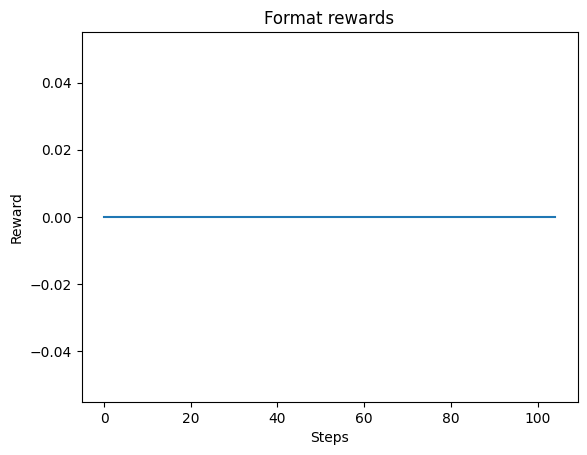

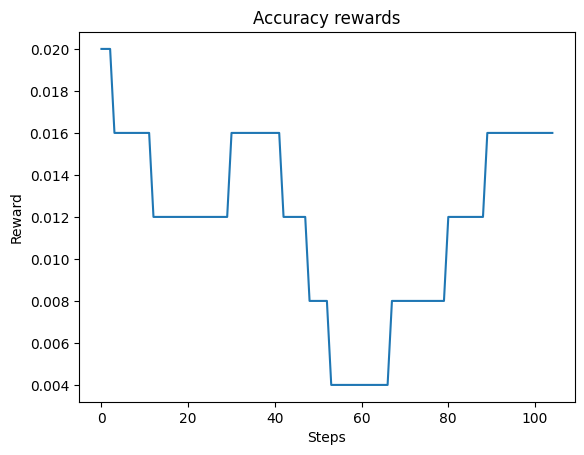

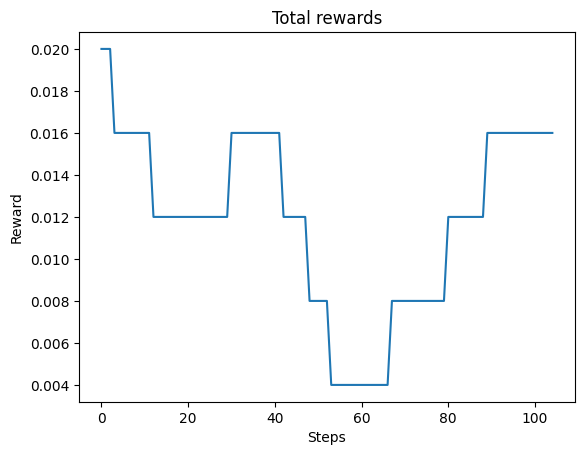

In [27]:
plt.plot(moving_average(track_format_rewards, window_size=100))
plt.title("Format rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(track_accuracy_rewards, window_size=100))
plt.title("Accuracy rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(total_rewards, window_size=100))
plt.title("Total rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()